

Графовые нейронные сети (GNN) становятся мощным инструментом в материаловедении, позволяя предсказывать свойства материалов на основе их атомной структуры. 

В этом ноутбуке исследуется применение GNN для анализа кристаллических структур с использованием графов Вороного — метода, который позволяет наиболее полно описать связи между атомами.


# **Цели работы:**
1. Построение полных графов на основе разбиения Вороного, чтобы корректно учесть все межатомные взаимодействия.  
2. Использование параметров Вороного (длины рёбер, площади граней, объёмы ячеек) в качестве признаков связей (edge_attr), что улучшает физическую интерпретируемость модели.  
3. Сравнение разных архитектур GNN  для предсказания свойств материалов. Тренируемся на прогнозировании энергии образования, используя небольшой датасет соединений Кремния (кубическая сингония, не более 3х элементов).  
4. Оптимизация модели с учётом особенностей кристаллических структур, включая периодические граничные условия.  

 **Ключевые особенности:**
- Данные представлены в виде графов, где узлы — атомы, а рёбра — связи Вороного.  
- Признаки узлов включают атомный номер, молярный объем, родство к электрону, максимальная и минимальная степени окисления.  
- Признаки рёбер (edge_attr) содержат геометрические параметры из разбиения Вороного.  
- Используется PyTorch Geometric для эффективной обработки графов.  



# Загрузка необходимых библиотек

In [1]:
from dotenv import load_dotenv # для загрузки ключа из файла .env
import os as os
from pymatgen.ext.matproj import MPRester
from tqdm import tqdm

In [2]:
import pandas as pd

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm, os
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error
from tqdm import tqdm

In [4]:
# MP API
from mp_api.client import MPRester

# Pymatgen
from pymatgen.io.vasp import Poscar

# Torch
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

from torch.nn import Linear


# Torch geometric
from torch_geometric.data import Data, Dataset
from torch_geometric.utils import to_networkx # визуализация графа
from torch_geometric.transforms import KNNGraph

from torch_geometric.loader import DataLoader as DataLoader_Graph

from torch_geometric.nn import PointTransformerConv, global_mean_pool

# Utils
import networkx as nx # Библиотека для работы с графами

In [5]:
from pymatgen.analysis.local_env import VoronoiNN # Класс для анализа соседства Вороного

In [6]:
# Сброс настроек
plt.rcParams.update(plt.rcParamsDefault)

import openpyxl #, работа с excel

In [7]:
import json
import numpy as np

# Ключ Materials Project API

In [49]:
# импортируем ключ API
load_dotenv()
mp_api_key = os.environ.get('MP_API_KEY')

Задача - загрузить датасет из базы данных Materials Project, обработать данные и преобразовать их в графы для дальнейшего обучения нейросети

# Загрузка данных

In [50]:
class DatasetBuilder:
    """
    Класс для создания датасета из базы данных Materials Project (MP).
    Обеспечивает:
    1. Подключение к API MP
    2. Выполнение запросов по заданным критериям
    3. Преобразование сырых данных в структурированный DataFrame
    4. Очистку данных от пропущенных значений

    Параметры:
    ----------
    criteria : dict, optional
        Словарь критериев поиска для MP API. Пример:
        {'elements': ['Li', 'Fe', 'O'], 'nelements': {'$lte': 3}}
    apikey : str, optional
        Ключ API для доступа к Materials Project. Если None, попытается
        использовать переменную окружения MAPI_KEY.
    """

    def __init__(self, criteria: dict = None, apikey: str = None):
        """Инициализация подключения к Materials Project API"""
        self.criteria = criteria or {}  # Критерии поиска (по умолчанию пустой словарь)
        self.apikey = apikey  # API ключ (может быть None)

        # Инициализация REST-клиента для работы с Materials Project API
        # Примечание: MPRester автоматически проверяет переменные окружения,
        # если apikey не указан явно
        self.rester = MPRester(apikey)  

    def query(self):
        """
        Выполняет запрос к Materials Project API с заданными критериями.
        Результаты сохраняются в self.docs как список документов (сырые данные).
        """
        # Используем защищенный метод _search для гибкого поиска
        # Возвращает генератор документов, который мы преобразуем в список
        self.docs = list(self.rester.summary._search(**self.criteria))  
        print(f"Найдено {len(self.docs)} материалов")

    @staticmethod
    def collect(doc=None):
        """
        Статический метод для преобразования документа MP в плоский словарь.
        
        Параметры:
        ----------
        doc : dict
            Сырой документ из Materials Project API
            
        Возвращает:
        ----------
        dict
            Очищенный словарь с данными материала
        """
        d = {}
        for i in doc:
            # Фильтрация данных:
            if len(i) == 2:
                if None not in i:  # 1. Пропускаем пары с None-значениями
                    if i[0] != 'fields_not_requested':  # 2. Исключаем служебное поле 'fields_not_requested'
                        d[i[0]] = i[1]
        return d

    def make_dataframe(self):
        """
        Преобразует сырые данные из self.docs в pandas DataFrame.
        Автоматически удаляет строки с пропущенными значениями.
        """
        df = pd.DataFrame()  # Создаем пустой DataFrame
        
        # Построчная обработка каждого документа
        for doc in self.docs:
            # Для каждого документа:
            # 1. Преобразуем в плоский словарь через collect()
            # 2. Создаем временный DataFrame из одной строки
            # 3. Объединяем с основным DataFrame
            df = pd.concat([
                df,
                pd.DataFrame([self.collect(doc)])  # [] для создания DataFrame из одной строки
            ], ignore_index=True)
        
        # Очистка данных:
        # 1. Удаление строк с пропущенными значениями
        # 2. Сброс индекса после удаления строк
        df = df.dropna()
        print('Финальный размер DataFrame:', df.shape)
        df = df.reset_index(drop=True)  # Сброс индекса без создания новой колонки
        self.dataframe = df  # Сохранение результата в атрибут класса

    def get_data(self):
        """
        Основной метод для получения данных. Выполняет:
        1. Запрос к API (query)
        2. Преобразование в DataFrame (make_dataframe)
        3. Возврат готовых данных
        
        Возвращает:
        ----------
        pd.DataFrame
            Очищенный DataFrame с данными материалов
        """
        self.query()  # Получаем сырые данные
        self.make_dataframe()  # Преобразуем в DataFrame
        return self.dataframe

In [52]:
# зафиксируем критерии запроса
requested_fields = [
    "composition", "structure", "formation_energy_per_atom", "material_id", "formula_pretty", 
            'symmetry'
]

criteria = {
    'nelements_max':3,
    'crystal_system': 'Cubic',
    'elements':['Si'],
    'fields':requested_fields,
    'num_chunks': 1,
    'chunk_size': 1000
}

In [53]:
# инициируем экземпляр класса с фиксированными критериями запроса
db_si_cubic_1000 = DatasetBuilder(criteria=criteria, apikey=mp_api_key)

In [54]:
db_si_cubic_1000

In [55]:
df_si_cubic_1000 = db_si_cubic_1000.get_data()

C:\Users\lazarevnv\AppData\Local\Temp\ipykernel_2184\1611926248.py:37: DeprecationWarning: Accessing summary data through MPRester.summary is deprecated. Please use MPRester.materials.summary instead.
  self.docs = list(self.rester.summary._search(**self.criteria))


Retrieving SummaryDoc documents:   0%|          | 0/562 [00:00<?, ?it/s]

Найдено 562 материалов
Финальный размер DataFrame: (562, 6)


In [15]:
df_si_cubic_1000[10:20]

,composition,formula_pretty,symmetry,material_id,structure,formation_energy_per_atom
10,"(Si, O)",SiO2,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-560836,"[[3.66050333 7.35399043 3.12668689] Si, [1.439...",-3.044315
11,"(Si, Tc)",SiTc,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1079910,"[[3.1091025 0.73605216 1.63699818] Si, [0.736...",-0.520418
12,"(Si, Ni)",SiNi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1095177,"[[2.94167781 0.68983081 1.56201619] Si, [0.689...",-0.374057
13,"(Mn, Si)",MnSi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1431,"[[3.87240559 2.85390008 1.6301892 ] Mn, [2.854...",-0.360732
14,"(Si, Rh)",SiRh,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1483,"[[0.74086379 1.60217555 3.08390314] Si, [1.602...",-0.800081
15,"(Si, Ru)",SiRu,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-189,"[[0.76478075 1.58951694 3.11907844] Si, [1.589...",-0.654533
16,"(Si, Os)",SiOs,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-2488,"[[0.78525696 1.59773892 3.16825284] Si, [1.597...",-0.392482
17,"(Cr, Si)",CrSi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-7576,"[[3.96529276 2.93399624 1.66552976] Cr, [2.933...",-0.142375
18,"(Co, Si)",CoSi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-7577,"[[3.74360675 2.8310704 1.5520477 ] Co, [2.831...",-0.492925
19,"(Re, Si)",ReSi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-7948,"[[4.13288122 3.02807868 1.74589459] Re, [3.028...",-0.264138


In [16]:
df_si_cubic_1000.tail(3)

,composition,formula_pretty,symmetry,material_id,structure,formation_energy_per_atom
559,"(Mg, Si, Bi)",Mg63Si32Bi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1194890,"[[9.4954585 0. 0. ] Mg, [0. ...",-0.066535
560,"(Mg, Si, Bi)",Mg64Si32Bi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1194936,"[[4.78909723 4.78909723 7.96644927] Mg, [4.789...",-0.049193
561,"(Na, Si)",NaSi34,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1220929,"[[11.040783 11.040783 11.040783] Na, [0. 0. 0....",0.113020


## Сохранение датафрейма

In [ ]:
# сохраняем датафрейм
PATH = r'C:\Users\lazarevnv\Desktop\github_repository\GNN_for_materials_1\data\full_graphs_voronoi_structures_562_Si_cubic\df_si_cubic_1000.xlsx'
df_si_cubic_1000.to_excel(PATH, index=False)

In [ ]:
# загружаем датафрейм
PATH = r'C:\Users\lazarevnv\Desktop\github_repository\GNN_for_materials_1\data\full_graphs_voronoi_structures_562_Si_cubic\df_si_cubic_1000.xlsx'
df_si_cubic_1000_load = pd.read_excel(PATH)

# Пример преобразования данных в граф torch_geometric.data

#### Формируем данные структуры supercell для примера

In [18]:
df_si_cubic_1000[10:11]

,composition,formula_pretty,symmetry,material_id,structure,formation_energy_per_atom
10,"(Si, O)",SiO2,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-560836,"[[3.66050333 7.35399043 3.12668689] Si, [1.439...",-3.044315


In [19]:
# определим id нашего примера
sample_idx = df_si_cubic_1000[10:11].index[0]
sample_idx

10

In [20]:
# получим струкруру из нашего примера
sample_struct = df_si_cubic_1000.loc[sample_idx, 'structure']
sample_struct

Structure Summary
Lattice
    abc : 8.793326 8.793326 8.793326
 angles : 90.0 90.0 90.0
 volume : 679.9226719388113
      A : 8.793326 0.0 0.0
      B : 0.0 8.793326 0.0
      C : 0.0 0.0 8.793326
    pbc : True True True
PeriodicSite: Si (3.661, 7.354, 3.127) [0.4163, 0.8363, 0.3556]
PeriodicSite: Si (1.439, 5.667, 3.661) [0.1637, 0.6444, 0.4163]
PeriodicSite: Si (3.127, 5.133, 1.439) [0.3556, 0.5837, 0.1637]
PeriodicSite: Si (7.354, 3.127, 3.661) [0.8363, 0.3556, 0.4163]
PeriodicSite: Si (7.354, 5.667, 5.133) [0.8363, 0.6444, 0.5837]
PeriodicSite: Si (5.133, 1.439, 3.127) [0.5837, 0.1637, 0.3556]
PeriodicSite: Si (3.127, 3.661, 7.354) [0.3556, 0.4163, 0.8363]
PeriodicSite: Si (5.133, 7.354, 5.667) [0.5837, 0.8363, 0.6444]
PeriodicSite: Si (5.667, 3.661, 1.439) [0.6444, 0.4163, 0.1637]
PeriodicSite: Si (1.439, 3.127, 5.133) [0.1637, 0.3556, 0.5837]
PeriodicSite: Si (5.667, 5.133, 7.354) [0.6444, 0.5837, 0.8363]
PeriodicSite: Si (3.661, 1.439, 5.667) [0.4163, 0.1637, 0.6444]
PeriodicSi

In [21]:
sample_target_value = df_si_cubic_1000.loc[sample_idx, 'formation_energy_per_atom']
sample_target_value

-3.044315215277778

In [22]:
# смотрим элемент структуры sites - местоположения
sample_struct.sites

[PeriodicSite: Si (3.661, 7.354, 3.127) [0.4163, 0.8363, 0.3556],
 PeriodicSite: Si (1.439, 5.667, 3.661) [0.1637, 0.6444, 0.4163],
 PeriodicSite: Si (3.127, 5.133, 1.439) [0.3556, 0.5837, 0.1637],
 PeriodicSite: Si (7.354, 3.127, 3.661) [0.8363, 0.3556, 0.4163],
 PeriodicSite: Si (7.354, 5.667, 5.133) [0.8363, 0.6444, 0.5837],
 PeriodicSite: Si (5.133, 1.439, 3.127) [0.5837, 0.1637, 0.3556],
 PeriodicSite: Si (3.127, 3.661, 7.354) [0.3556, 0.4163, 0.8363],
 PeriodicSite: Si (5.133, 7.354, 5.667) [0.5837, 0.8363, 0.6444],
 PeriodicSite: Si (5.667, 3.661, 1.439) [0.6444, 0.4163, 0.1637],
 PeriodicSite: Si (1.439, 3.127, 5.133) [0.1637, 0.3556, 0.5837],
 PeriodicSite: Si (5.667, 5.133, 7.354) [0.6444, 0.5837, 0.8363],
 PeriodicSite: Si (3.661, 1.439, 5.667) [0.4163, 0.1637, 0.6444],
 PeriodicSite: O (4.397, 0.0, 2.946) [0.5, 0.0, 0.335],
 PeriodicSite: O (4.397, 0.0, 5.847) [0.5, 0.0, 0.665],
 PeriodicSite: O (7.182, 3.655, 2.094) [0.8168, 0.4157, 0.2382],
 PeriodicSite: O (2.184, 4.397,

In [23]:
type(sample_struct)

pymatgen.core.structure.Structure

In [24]:
# Создаем суперячейку 2x2x2 для корректного учета периодических границ
supercell = sample_struct.copy()

In [25]:
supercell

Structure Summary
Lattice
    abc : 8.793326 8.793326 8.793326
 angles : 90.0 90.0 90.0
 volume : 679.9226719388113
      A : 8.793326 0.0 0.0
      B : 0.0 8.793326 0.0
      C : 0.0 0.0 8.793326
    pbc : True True True
PeriodicSite: Si (3.661, 7.354, 3.127) [0.4163, 0.8363, 0.3556]
PeriodicSite: Si (1.439, 5.667, 3.661) [0.1637, 0.6444, 0.4163]
PeriodicSite: Si (3.127, 5.133, 1.439) [0.3556, 0.5837, 0.1637]
PeriodicSite: Si (7.354, 3.127, 3.661) [0.8363, 0.3556, 0.4163]
PeriodicSite: Si (7.354, 5.667, 5.133) [0.8363, 0.6444, 0.5837]
PeriodicSite: Si (5.133, 1.439, 3.127) [0.5837, 0.1637, 0.3556]
PeriodicSite: Si (3.127, 3.661, 7.354) [0.3556, 0.4163, 0.8363]
PeriodicSite: Si (5.133, 7.354, 5.667) [0.5837, 0.8363, 0.6444]
PeriodicSite: Si (5.667, 3.661, 1.439) [0.6444, 0.4163, 0.1637]
PeriodicSite: Si (1.439, 3.127, 5.133) [0.1637, 0.3556, 0.5837]
PeriodicSite: Si (5.667, 5.133, 7.354) [0.6444, 0.5837, 0.8363]
PeriodicSite: Si (3.661, 1.439, 5.667) [0.4163, 0.1637, 0.6444]
PeriodicSi

In [26]:
# смотрим количество атомов в ячейке
len(supercell)

36

In [27]:
# Создаем суперячейку 2x2x2 для корректного учета периодических границ
supercell.make_supercell([2, 2, 2])  # Теперь минимум 8 атомов (если в ячейке был 1 атом)

Structure Summary
Lattice
    abc : 17.586652 17.586652 17.586652
 angles : 90.0 90.0 90.0
 volume : 5439.38137551049
      A : 17.586652 0.0 0.0
      B : 0.0 17.586652 0.0
      C : 0.0 0.0 17.586652
    pbc : True True True
PeriodicSite: Si (3.661, 7.354, 3.127) [0.2081, 0.4182, 0.1778]
PeriodicSite: Si (3.661, 7.354, 11.92) [0.2081, 0.4182, 0.6778]
PeriodicSite: Si (3.661, 16.15, 3.127) [0.2081, 0.9182, 0.1778]
PeriodicSite: Si (3.661, 16.15, 11.92) [0.2081, 0.9182, 0.6778]
PeriodicSite: Si (12.45, 7.354, 3.127) [0.7081, 0.4182, 0.1778]
PeriodicSite: Si (12.45, 7.354, 11.92) [0.7081, 0.4182, 0.6778]
PeriodicSite: Si (12.45, 16.15, 3.127) [0.7081, 0.9182, 0.1778]
PeriodicSite: Si (12.45, 16.15, 11.92) [0.7081, 0.9182, 0.6778]
PeriodicSite: Si (1.439, 5.667, 3.661) [0.08184, 0.3222, 0.2081]
PeriodicSite: Si (1.439, 5.667, 12.45) [0.08184, 0.3222, 0.7081]
PeriodicSite: Si (1.439, 14.46, 3.661) [0.08184, 0.8222, 0.2081]
PeriodicSite: Si (1.439, 14.46, 12.45) [0.08184, 0.8222, 0.7081]
P

In [28]:
# смотрим количество атомов в ячейке после получения суперячейки
len(supercell)

288

In [29]:
supercell.lattice

Lattice
    abc : 17.586652 17.586652 17.586652
 angles : 90.0 90.0 90.0
 volume : 5439.38137551049
      A : 17.586652 0.0 0.0
      B : 0.0 17.586652 0.0
      C : 0.0 0.0 17.586652
    pbc : True True True

In [30]:
# смотрим свойства элемента
supercell.species[0]

Element Si

In [31]:
# смотрим свойства элемента
supercell.sites[0].species.elements[0]

Element Si

In [32]:
# смотрим свойства элемента
supercell.sites[0].species.elements[0].Z

14

In [33]:
# смотрим свойства элемента
supercell.sites[0].species.elements[0].molar_volume

12.06

In [34]:
# смотрим свойства элемента
supercell.sites[0].species.elements[0].electron_affinity

1.38952128

#### Преобразуем atoms - атомные свойства и pos - координаты

In [35]:
# Инициализация пустых списков для хранения атомных свойств и координат
atoms, pos = [], []

In [36]:
# добавим атомные свойства и координаты в отдельные переменные типа [list]
for site in sample_struct.sites:
    atoms.append([
        site.species.elements[0].Z, # Атомный номер (количество протонов)
        site.species.elements[0].molar_volume, # Молярный объем
        site.species.elements[0].electron_affinity,  # Сродство к электрону
        site.species.elements[0].min_oxidation_state, # Минимальная степень окисления
        site.species.elements[0].max_oxidation_state, # Максимальная степень окисления
    ])

     # Добавляем координаты атома в pos
    pos.append(site.coords)  # Декартовы координаты [x, y, z]

In [37]:
atoms

[[14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4

In [38]:
pos

[array([3.66050333, 7.35399043, 3.12668689]),
 array([1.43933557, 5.66663911, 3.66050333]),
 array([3.12668689, 5.13282267, 1.43933557]),
 array([7.35399043, 3.12668689, 3.66050333]),
 array([7.35399043, 5.66663911, 5.13282267]),
 array([5.13282267, 1.43933557, 3.12668689]),
 array([3.12668689, 3.66050333, 7.35399043]),
 array([5.13282267, 7.35399043, 5.66663911]),
 array([5.66663911, 3.66050333, 1.43933557]),
 array([1.43933557, 3.12668689, 5.13282267]),
 array([5.66663911, 5.13282267, 7.35399043]),
 array([3.66050333, 1.43933557, 5.66663911]),
 array([4.396663  , 0.        , 2.94586973]),
 array([4.396663  , 0.        , 5.84745627]),
 array([7.1822216 , 3.65549993, 2.09423611]),
 array([2.18393683, 4.396663  , 4.396663  ]),
 array([6.69908989, 7.1822216 , 5.13782607]),
 array([5.13782607, 2.09423611, 1.6111044 ]),
 array([3.65549993, 6.69908989, 1.6111044 ]),
 array([2.09423611, 1.6111044 , 5.13782607]),
 array([0.        , 5.84745627, 4.396663  ]),
 array([6.60938917, 4.396663  , 4.

In [39]:
# torch_geometric is designed to work with torch.tensor objects 
# (torch_geometric предназначен для работы с объектами torch.tensor)

# Преобразование списков в тензоры PyTorch для совместимости с torch_geometric
atoms = torch.tensor(atoms).to(torch.float32)  # Преобразуем в тензор float32
pos = torch.tensor(pos).to(torch.float32)      # Координаты также в float32

C:\Users\lazarevnv\AppData\Local\Temp\ipykernel_22332\2466273431.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  pos = torch.tensor(pos).to(torch.float32)      # Координаты также в float32


In [40]:
# смотрим что получилось
atoms

tensor([[14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 

In [41]:
# смотрим что получилось
pos

tensor([[3.6605, 7.3540, 3.1267],
        [1.4393, 5.6666, 3.6605],
        [3.1267, 5.1328, 1.4393],
        [7.3540, 3.1267, 3.6605],
        [7.3540, 5.6666, 5.1328],
        [5.1328, 1.4393, 3.1267],
        [3.1267, 3.6605, 7.3540],
        [5.1328, 7.3540, 5.6666],
        [5.6666, 3.6605, 1.4393],
        [1.4393, 3.1267, 5.1328],
        [5.6666, 5.1328, 7.3540],
        [3.6605, 1.4393, 5.6666],
        [4.3967, 0.0000, 2.9459],
        [4.3967, 0.0000, 5.8475],
        [7.1822, 3.6555, 2.0942],
        [2.1839, 4.3967, 4.3967],
        [6.6991, 7.1822, 5.1378],
        [5.1378, 2.0942, 1.6111],
        [3.6555, 6.6991, 1.6111],
        [2.0942, 1.6111, 5.1378],
        [0.0000, 5.8475, 4.3967],
        [6.6094, 4.3967, 4.3967],
        [4.3967, 6.6094, 4.3967],
        [0.0000, 2.9459, 4.3967],
        [7.1822, 5.1378, 6.6991],
        [3.6555, 2.0942, 7.1822],
        [4.3967, 4.3967, 2.1839],
        [1.6111, 3.6555, 6.6991],
        [1.6111, 5.1378, 2.0942],
        [5.847

#### Данные Вороного

In [42]:
# Настройка параметров анализа Вороного
vnn = VoronoiNN(
    cutoff=5.0,  # Максимальное расстояние между атомами для учёта связи (в ангстремах)
    weight="area",  # Вес ребра графа = площадь грани ячейки Вороного (можно также "solid_angle")
    tol=0.5,  # Минимальная допустимая площадь грани (игнорирует слишком малые грани)
)
# VoronoiNN — класс, который находит соседей на основе диаграммы Вороного

In [43]:
# Создание пустого неориентированного графа
example_graph_voronoi = nx.Graph()
# nx.Graph() создаёт объект графа (неориентированного, без узлов и рёбер)

In [44]:
example_graph_voronoi

In [ ]:
# for site in sample_struct.sites:
#     print(site)

[3.66050333 7.35399043 3.12668689] Si
[1.43933557 5.66663911 3.66050333] Si
[3.12668689 5.13282267 1.43933557] Si
[7.35399043 3.12668689 3.66050333] Si
[7.35399043 5.66663911 5.13282267] Si
[5.13282267 1.43933557 3.12668689] Si
[3.12668689 3.66050333 7.35399043] Si
[5.13282267 7.35399043 5.66663911] Si
[5.66663911 3.66050333 1.43933557] Si
[1.43933557 3.12668689 5.13282267] Si
[5.66663911 5.13282267 7.35399043] Si
[3.66050333 1.43933557 5.66663911] Si
[4.396663   0.         2.94586973] O
[4.396663   0.         5.84745627] O
[7.1822216  3.65549993 2.09423611] O
[2.18393683 4.396663   4.396663  ] O
[6.69908989 7.1822216  5.13782607] O
[5.13782607 2.09423611 1.6111044 ] O
[3.65549993 6.69908989 1.6111044 ] O
[2.09423611 1.6111044  5.13782607] O
[0.         5.84745627 4.396663  ] O
[6.60938917 4.396663   4.396663  ] O
[4.396663   6.60938917 4.396663  ] O
[0.         2.94586973 4.396663  ] O
[7.1822216  5.13782607 6.69908989] O
[3.65549993 2.09423611 7.1822216 ] O
[4.396663   4.396663   2.1

In [78]:
for i, site in enumerate(sample_struct):
    print(site)

[3.66050333 7.35399043 3.12668689] Si
[1.43933557 5.66663911 3.66050333] Si
[3.12668689 5.13282267 1.43933557] Si
[7.35399043 3.12668689 3.66050333] Si
[7.35399043 5.66663911 5.13282267] Si
[5.13282267 1.43933557 3.12668689] Si
[3.12668689 3.66050333 7.35399043] Si
[5.13282267 7.35399043 5.66663911] Si
[5.66663911 3.66050333 1.43933557] Si
[1.43933557 3.12668689 5.13282267] Si
[5.66663911 5.13282267 7.35399043] Si
[3.66050333 1.43933557 5.66663911] Si
[4.396663   0.         2.94586973] O
[4.396663   0.         5.84745627] O
[7.1822216  3.65549993 2.09423611] O
[2.18393683 4.396663   4.396663  ] O
[6.69908989 7.1822216  5.13782607] O
[5.13782607 2.09423611 1.6111044 ] O
[3.65549993 6.69908989 1.6111044 ] O
[2.09423611 1.6111044  5.13782607] O
[0.         5.84745627 4.396663  ] O
[6.60938917 4.396663   4.396663  ] O
[4.396663   6.60938917 4.396663  ] O
[0.         2.94586973 4.396663  ] O
[7.1822216  5.13782607 6.69908989] O
[3.65549993 2.09423611 7.1822216 ] O
[4.396663   4.396663   2.1

In [77]:
for i, site in enumerate(supercell):
    print(site)

[3.66050333 7.35399043 3.12668689] Si
[ 3.66050333  7.35399043 11.92001289] Si
[ 3.66050333 16.14731643  3.12668689] Si
[ 3.66050333 16.14731643 11.92001289] Si
[12.45382933  7.35399043  3.12668689] Si
[12.45382933  7.35399043 11.92001289] Si
[12.45382933 16.14731643  3.12668689] Si
[12.45382933 16.14731643 11.92001289] Si
[1.43933557 5.66663911 3.66050333] Si
[ 1.43933557  5.66663911 12.45382933] Si
[ 1.43933557 14.45996511  3.66050333] Si
[ 1.43933557 14.45996511 12.45382933] Si
[10.23266157  5.66663911  3.66050333] Si
[10.23266157  5.66663911 12.45382933] Si
[10.23266157 14.45996511  3.66050333] Si
[10.23266157 14.45996511 12.45382933] Si
[3.12668689 5.13282267 1.43933557] Si
[ 3.12668689  5.13282267 10.23266157] Si
[ 3.12668689 13.92614867  1.43933557] Si
[ 3.12668689 13.92614867 10.23266157] Si
[11.92001289  5.13282267  1.43933557] Si
[11.92001289  5.13282267 10.23266157] Si
[11.92001289 13.92614867  1.43933557] Si
[11.92001289 13.92614867 10.23266157] Si
[7.35399043 3.12668689 3.

In [ ]:
# Построение графа: перебор всех атомов и их соседей
for i, site in enumerate(sample_struct):  
    # i — индекс атома, site — объект атома (с координатами, типом и т. д.)
    print('\n\n')

    
    neighbors = vnn.get_nn_info(sample_struct, i)  
    # Получение списка соседей для атома с индексом i

    for neighbor in neighbors: # Перебор всех соседей текущего атома
        # print('\n')

        # Базовые параметры (site, site_index) нужны для идентификации атомов.
        neighbor_index = neighbor["site_index"] # Индекс соседнего атома ("site_index" — ключ в словаре neighbor)
        print('neighbor_index', neighbor_index)
        
        # Пороговые значения (weight, face_dist) помогают фильтровать "слабые" связи.
        weight = neighbor["weight"] # Вес ребра (площадь грани Вороного, так как weight="area")
        print('weight', weight)
        distance=neighbor['site'].distance(sample_struct[i]) # Полное расстояние между центрами двух атомов.
        print('distance', distance)
        face_dist = neighbor['poly_info']["face_dist"] # Расстояние до грани Расстояние от центра атома до грани Вороного (в Å).
        print('face_dist', face_dist)
        solid_angle = neighbor['poly_info']["solid_angle"]  # Телесный угол (если weight="solid_angle") 
        # Телесный угол (в стерадианах), под которым видна грань из центра атома. Характеризует "важность" связи.
        print('solid_angle', solid_angle)
        
        # Детальная геометрическая информация (poly_info)
        # Геометрические параметры (normal, area, volume) позволяют анализировать локальное окружение.
        volume = neighbor['poly_info']["volume"]  # Объём ячейки Вороного для текущего атома (в Å³).
        print('volume', volume)
        normal=list(neighbor['poly_info']['normal']) # Нормаль к грани. Единичный вектор нормали к грани Вороного между ячейками. Направлен от текущего атома к соседу.
        # Применение: Анализ ориентации связей в анизотропных материалах.
        print('normal', normal)
        area=neighbor['poly_info']['area'] # Площадь грани
        print('area', area)
        
        example_graph_voronoi.add_edge(i, 
                                       neighbor_index, # Индекс соседнего атома ("site_index" — ключ в словаре neighbor)
                                       weight=weight,  # Вес ребра (площадь грани Вороного, так как weight="area")
                                       distance=distance,  # Полное расстояние между центрами двух атомов.
                                       face_dist=face_dist, # Расстояние до грани Расстояние от центра атома до грани Вороного (в Å).
                                       solid_angle=solid_angle, # Телесный угол (если weight="solid_angle") # Телесный угол (в стерадианах), под которым видна грань из центра атома. Характеризует "важность" связи.
                                       volume=volume, # Объём ячейки Вороного для текущего атома (в Å³).
                                       normal=normal, # Нормаль к грани. Единичный вектор нормали к грани Вороного между ячейками. Направлен от текущего атома к соседу.
        # Применение: Анализ ориентации связей в анизотропных материалах.
                                       area=area # Площадь грани
                                       )   




neighbor_index 12
weight 1.0
distance 1.6267491425104843
face_dist 0.8133745712552422
solid_angle 3.190058725358445
volume 1.9940505918888574
normal [0.45253422720845576, 0.8847925772309003, -0.11115245603200606]
area 7.354731739934533
neighbor_index 35
weight 0.8767203737408025
distance 1.662029117657795
face_dist 0.8310145588288975
solid_angle 2.9833866683118
volume 1.7861392472499487
normal [-0.942382543410107, -0.10334886931828013, 0.3181731495373722]
area 6.448043159798747
neighbor_index 18
weight 0.9412516560959052
distance 1.6510330264224433
face_dist 0.8255165132112217
solid_angle 3.0825671592235824
volume 1.9049215739986494
normal [-0.0030304678428156257, -0.39666107825902713, -0.9179601327176685]
area 6.922653430354498
neighbor_index 22
weight 0.8588871272795183
distance 1.6459651887689692
face_dist 0.8229825943844847
solid_angle 2.9942270370128417
volume 1.732895308375414
normal [0.44725105433036516, -0.45237971258972043, 0.7715692386543275]
area 6.316884416023865



neig

In [ ]:
# Добавление атрибутов для узлов графа (атомов)
for i, site in enumerate(sample_struct):  
    # Аналогичный перебор всех атомов   
    
    example_graph_voronoi.nodes[i]["Z"] = site.species.elements[0].Z # Атомный номер (количество протонов)
    example_graph_voronoi.nodes[i]["molar_volume"] = site.species.elements[0].molar_volume # Молярный объем
    example_graph_voronoi.nodes[i]["electron_affinity"] = site.species.elements[0].electron_affinity  # Сродство к электрону
    example_graph_voronoi.nodes[i]["min_oxidation_state"] = site.species.elements[0].min_oxidation_state # Минимальная степень окисления
    example_graph_voronoi.nodes[i]["max_oxidation_state"] = site.species.elements[0].max_oxidation_state # Максимальная степень окисления

    example_graph_voronoi.nodes[i]['coordination_number'] = len(vnn.get_nn_info(sample_struct, i))  # Координационное число
    
    example_graph_voronoi.nodes[i]["element"] = site.species_string  # обозначение элемента 
    # Запись химического элемента атома в атрибут узла "element"
    # site.species_string возвращает строку (например, "Fe", "O")
    
    # example_graph_voronoi.nodes[i]["coords"] = site.coords  
    # Запись координат атома [x, y, z] в атрибут узла "coords"

In [50]:
# Преобразование узлов
x_voronoi = []

for node in set(example_graph_voronoi.nodes):
    # element = 0 if example_graph_voronoi.nodes[node]['element'] == 'Si' else 1
    Z = example_graph_voronoi.nodes[node]['Z']
    molar_volume = example_graph_voronoi.nodes[node]['molar_volume']
    electron_affinity = example_graph_voronoi.nodes[node]['electron_affinity']
    min_oxidation_state = example_graph_voronoi.nodes[node]['min_oxidation_state']
    max_oxidation_state = example_graph_voronoi.nodes[node]['max_oxidation_state']
    coordination_number = example_graph_voronoi.nodes[node]['coordination_number']
    # coords = example_graph_voronoi.nodes[node]['coords']

    x_voronoi.append([Z, molar_volume, electron_affinity, min_oxidation_state, max_oxidation_state, coordination_number])
x_voronoi = torch.tensor(x_voronoi, dtype=torch.float)

In [51]:
type(example_graph_voronoi[12])

networkx.classes.coreviews.AtlasView

In [52]:
x_voronoi

tensor([[14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0

In [53]:
# Преобразование рёбер
edge_index = []
edge_attr = []
for u, v in example_graph_voronoi.edges:
    edge_index.append([u, v])
    edge_attr.append([
        example_graph_voronoi.edges[u,v]['weight'],
        example_graph_voronoi.edges[u,v]['distance'],
        example_graph_voronoi.edges[u,v]['face_dist'],
        example_graph_voronoi.edges[u,v]['solid_angle'],
        example_graph_voronoi.edges[u,v]['volume'],
        # example_graph_voronoi.edges[u,v]['normal'],
        example_graph_voronoi.edges[u,v]['area']
    ])

In [54]:
# Переводим данные в тензоры
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
# Переводим данные в тензоры
# edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

#### создадим тензор lattice для параметров решетки - векторов трансляций 

In [55]:
supercell

Structure Summary
Lattice
    abc : 17.586652 17.586652 17.586652
 angles : 90.0 90.0 90.0
 volume : 5439.38137551049
      A : 17.586652 0.0 0.0
      B : 0.0 17.586652 0.0
      C : 0.0 0.0 17.586652
    pbc : True True True
PeriodicSite: Si (3.661, 7.354, 3.127) [0.2081, 0.4182, 0.1778]
PeriodicSite: Si (3.661, 7.354, 11.92) [0.2081, 0.4182, 0.6778]
PeriodicSite: Si (3.661, 16.15, 3.127) [0.2081, 0.9182, 0.1778]
PeriodicSite: Si (3.661, 16.15, 11.92) [0.2081, 0.9182, 0.6778]
PeriodicSite: Si (12.45, 7.354, 3.127) [0.7081, 0.4182, 0.1778]
PeriodicSite: Si (12.45, 7.354, 11.92) [0.7081, 0.4182, 0.6778]
PeriodicSite: Si (12.45, 16.15, 3.127) [0.7081, 0.9182, 0.1778]
PeriodicSite: Si (12.45, 16.15, 11.92) [0.7081, 0.9182, 0.6778]
PeriodicSite: Si (1.439, 5.667, 3.661) [0.08184, 0.3222, 0.2081]
PeriodicSite: Si (1.439, 5.667, 12.45) [0.08184, 0.3222, 0.7081]
PeriodicSite: Si (1.439, 14.46, 3.661) [0.08184, 0.8222, 0.2081]
PeriodicSite: Si (1.439, 14.46, 12.45) [0.08184, 0.8222, 0.7081]
P

In [56]:
sample_struct.sites

[PeriodicSite: Si (3.661, 7.354, 3.127) [0.4163, 0.8363, 0.3556],
 PeriodicSite: Si (1.439, 5.667, 3.661) [0.1637, 0.6444, 0.4163],
 PeriodicSite: Si (3.127, 5.133, 1.439) [0.3556, 0.5837, 0.1637],
 PeriodicSite: Si (7.354, 3.127, 3.661) [0.8363, 0.3556, 0.4163],
 PeriodicSite: Si (7.354, 5.667, 5.133) [0.8363, 0.6444, 0.5837],
 PeriodicSite: Si (5.133, 1.439, 3.127) [0.5837, 0.1637, 0.3556],
 PeriodicSite: Si (3.127, 3.661, 7.354) [0.3556, 0.4163, 0.8363],
 PeriodicSite: Si (5.133, 7.354, 5.667) [0.5837, 0.8363, 0.6444],
 PeriodicSite: Si (5.667, 3.661, 1.439) [0.6444, 0.4163, 0.1637],
 PeriodicSite: Si (1.439, 3.127, 5.133) [0.1637, 0.3556, 0.5837],
 PeriodicSite: Si (5.667, 5.133, 7.354) [0.6444, 0.5837, 0.8363],
 PeriodicSite: Si (3.661, 1.439, 5.667) [0.4163, 0.1637, 0.6444],
 PeriodicSite: O (4.397, 0.0, 2.946) [0.5, 0.0, 0.335],
 PeriodicSite: O (4.397, 0.0, 5.847) [0.5, 0.0, 0.665],
 PeriodicSite: O (7.182, 3.655, 2.094) [0.8168, 0.4157, 0.2382],
 PeriodicSite: O (2.184, 4.397,

In [57]:
sample_struct.lattice

Lattice
    abc : 8.793326 8.793326 8.793326
 angles : 90.0 90.0 90.0
 volume : 679.9226719388113
      A : 8.793326 0.0 0.0
      B : 0.0 8.793326 0.0
      C : 0.0 0.0 8.793326
    pbc : True True True

In [58]:
sample_struct.lattice.matrix

array([[8.793326, 0.      , 0.      ],
       [0.      , 8.793326, 0.      ],
       [0.      , 0.      , 8.793326]])

In [59]:
torch.tensor(sample_struct.lattice.matrix)

tensor([[8.7933, 0.0000, 0.0000],
        [0.0000, 8.7933, 0.0000],
        [0.0000, 0.0000, 8.7933]], dtype=torch.float64)

In [60]:
torch.tensor(sample_struct.lattice.matrix, dtype=torch.float32)

tensor([[8.7933, 0.0000, 0.0000],
        [0.0000, 8.7933, 0.0000],
        [0.0000, 0.0000, 8.7933]])

In [61]:
torch.tensor(sample_struct.lattice.matrix, dtype=torch.float32).flatten()

tensor([8.7933, 0.0000, 0.0000, 0.0000, 8.7933, 0.0000, 0.0000, 0.0000, 8.7933])

In [62]:
torch.tensor(sample_struct.lattice.matrix, dtype=torch.float32).flatten().unsqueeze(0)

tensor([[8.7933, 0.0000, 0.0000, 0.0000, 8.7933, 0.0000, 0.0000, 0.0000, 8.7933]])

In [63]:
# создадим тензор для параметров решетки - векторов трансляций 
lattice_translational_vectors = torch.tensor(sample_struct.lattice.matrix, dtype=torch.float32).flatten().unsqueeze(0)

In [64]:
lattice_translational_vectors

tensor([[8.7933, 0.0000, 0.0000, 0.0000, 8.7933, 0.0000, 0.0000, 0.0000, 8.7933]])

На следующем шаге мы создадим специальную структуру данных `torch_geometric.data.Данные` - основу для будущего графа. В эту структуру мы поместим собранную информацию об узлах графа. 

In [65]:
# # создаём структуру данных, помоему это и есть граф
# graph = Data(x=atoms, pos=pos)

In [66]:
atoms

tensor([[14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 

In [67]:
x_voronoi

tensor([[14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0

In [68]:
# создаём структуру данных, помоему это и есть граф
graph_full = Data(x=atoms, 
                  x_voronoi=x_voronoi,
                  y=torch.tensor([sample_target_value], dtype=torch.float),  # Целевое значение
                  positions=pos, 
                  lattice_translational_vectors=lattice_translational_vectors,
                  edge_index=edge_index,
                  edge_attr=edge_attr
                  )

In [69]:
graph_full

Data(x=[36, 5], edge_index=[2, 108], edge_attr=[108, 6], y=[1], x_voronoi=[36, 6], positions=[36, 3], lattice_translational_vectors=[1, 9])

In [70]:
graph_full.x

tensor([[14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 

In [71]:
graph_full.x_voronoi

tensor([[14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0

In [72]:
# это тип данных из библиотеки torch_geometric.data
type(graph_full)

torch_geometric.data.data.Data

In [73]:
# смотрим какие есть ключи в графе
graph_full.keys()

['edge_attr',
 'x_voronoi',
 'y',
 'positions',
 'lattice_translational_vectors',
 'edge_index',
 'x']

In [74]:
graph_full.lattice_translational_vectors

tensor([[8.7933, 0.0000, 0.0000, 0.0000, 8.7933, 0.0000, 0.0000, 0.0000, 8.7933]])

In [75]:
graph_full.edge_index

tensor([[ 0,  0,  0,  0, 12, 12, 12, 35, 35, 35, 35, 35, 35, 35, 18, 18, 18, 18,
         18, 22, 22, 22, 22, 22, 22,  1,  1,  1, 15, 15, 15, 15, 15, 15, 20, 20,
         28, 28, 28, 28,  2,  2, 26, 26, 26, 26, 31, 31,  3,  3,  3,  3, 14, 14,
         14, 14, 14, 14, 23, 23, 23, 30, 30, 30, 30, 30, 21, 21, 21, 21,  4,  4,
         24, 24, 24, 24, 24, 16, 16,  5,  5, 34, 34, 34, 17, 17,  6,  6,  6, 32,
         32, 32, 25, 25, 25, 25, 25, 27, 27,  7,  7, 33, 33, 13,  8, 29,  9, 19],
        [12, 35, 18, 22,  5, 18, 17,  1, 16, 19, 20, 22, 28, 18,  2, 17, 33, 28,
         26,  7, 15, 21, 26, 32, 16, 15, 20, 28,  9, 26, 28, 27, 34, 32,  4, 16,
          2, 14, 27, 31, 26, 31,  8, 21, 34, 17,  6, 27, 14, 23, 30, 21,  8, 29,
         24, 30, 17, 21,  9, 19, 30,  5, 16, 19, 17, 34,  4, 34, 32, 24, 24, 16,
         10, 27, 29, 16, 33,  7, 33, 34, 17, 11, 32, 19,  8, 25, 32, 25, 27, 10,
         25, 33, 11, 13, 19, 33, 27,  9, 19, 33, 13, 10, 13, 11, 29, 10, 19, 11]])

#### Визуализируем граф

После создания соединений мы будем использовать библиотеку [`NetworkX`](https://networkx.org/documentation/stable/tutorial.html) для визуализации результирующего графа. Чтобы упростить работу с этой библиотекой, воспользуемся torch_geometric.data.Данные` имеет встроенный метод "to_networkx`. 

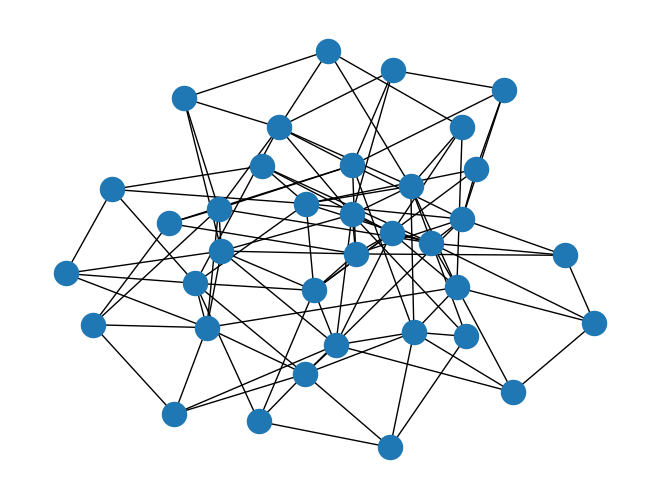

In [ ]:
nx_graph = to_networkx(graph_full, to_undirected=True) 
# Параметр to_undirected=True объединяет направленные ребра в неориентированные
nx.draw(nx_graph)
plt.show()

# Построение датасета c помощью Voronoi в том числе

### Функция преобразования в граф

определим функцию для преобразования структур в графы в формате данных torch_geometric: 

In [91]:
def get_graph(struct, y: float) -> Data:
    """
    Преобразует кристаллическую структуру (pymatgen.Structure) в граф (torch_geometric.data.Data)
    для использования в CGNN (я так понял, что для обучения, т.к. есть целевое свойство). 
    Граф включает:
    - Узлы: атомы с признаками (атомный номер, молярный объем и др.)
    - Ребра: связи между атомами (k-NN, k=6)
    - Глобальные свойства: энергия (y) и параметры решетки.

    Параметры:
    ----------
    struct : pymatgen.Structure
        Кристаллическая структура из pymatgen.
    y : float
        Целевое свойство (например, энергия образования).

    Возвращает:
    -----------
    torch_geometric.data.Data
        Граф с полями:
        - x (Tensor): Признаки узлов [num_atoms, num_features].
        - pos (Tensor): Координаты атомов [num_atoms, 3].
        - lattice (Tensor): Параметры решетки [1, 9].
        - y (Tensor): Целевое свойство [1, 1].
        - edge_index (Tensor): Индексы связей [2, num_edges].

    Пример использования:
    ---------------------
    >>> sample_struct = df.iloc[0]['structure']
    >>> sample_energy = df.iloc[0]['formation_energy_per_atom']
    >>> graph = get_graph(sample_struct, sample_energy)
    """
    # Создаем суперячейку 2x2x2 для корректного учета периодических границ
    supercell = struct.copy()
    # Повторяем ячейку 2×2×2 раза по осям a, b, c
    supercell.make_supercell([2, 2, 2])  # Теперь минимум 8 атомов (если в ячейке был 1 атом)

    # Признаки узлов (атомов):
    # -------------------------
    # Каждый атом описывается вектором [Z, molar_volume, electron_affinity, min_oxidation_state, max_oxidation_state]
    x = []
    for site in supercell:
        elem = site.species.elements[0]  # Берем первый элемент (на случай неупорядоченных структур)
        x.append([
            elem.Z,                      # Атомный номер
            elem.molar_volume,           # Молярный объем (из pymatgen)
            elem.electron_affinity,      # Сродство к электрону (эВ)
            elem.min_oxidation_state,    # Минимальная степень окисления
            elem.max_oxidation_state,    # Максимальная степень окисления
        ])
    # преобразование данных в тензоры PyTorch
    x = torch.tensor(x, dtype=torch.float32)  # [num_atoms, 5]

    # Декартовы координаты атомов (используются для построения графа)
    pos = torch.tensor(supercell.cart_coords, dtype=torch.float32)  # [num_atoms, 3]

    # Параметры решетки (хранятся как flatten-вектор 3x3=9 компонент)
    lattice = torch.tensor(supercell.lattice.matrix, dtype=torch.float32).flatten().unsqueeze(0)  # [1, 9]

    # Целевое свойство (например, энергия образования)
    y = torch.tensor([[y]], dtype=torch.float32) # [1, 1]

    # Настройка параметров анализа Вороного
    vnn = VoronoiNN(
        cutoff=5.0,  # Максимальное расстояние между атомами для учёта связи (в ангстремах)
        weight="area",  # Вес ребра графа = площадь грани ячейки Вороного (можно также "solid_angle")
        tol=0.5,  # Минимальная допустимая площадь грани (игнорирует слишком малые грани)
    )
    # VoronoiNN — класс, который находит соседей на основе диаграммы Вороного

    # Создание пустого неориентированного графа
    graph_voronoi = nx.Graph()
    # nx.Graph() создаёт объект графа (неориентированного, без узлов и рёбер)

    # Построение графа: перебор всех атомов и их соседей
    for i, site in enumerate(supercell):
        # i — индекс атома, site — объект атома (с координатами, типом и т. д.)
        # print('\n\n')

        
        neighbors = vnn.get_nn_info(supercell, i)  
        # Получение списка соседей для атома с индексом i

        for neighbor in neighbors: # Перебор всех соседей текущего атома
            # print('\n')

            # Базовые параметры (site, site_index) нужны для идентификации атомов.
            neighbor_index = neighbor["site_index"] # Индекс соседнего атома ("site_index" — ключ в словаре neighbor)
            # print('neighbor_index', neighbor_index)
            
            # Пороговые значения (weight, face_dist) помогают фильтровать "слабые" связи.
            weight = neighbor["weight"] # Вес ребра (площадь грани Вороного, так как weight="area")
            # print('weight', weight)
            distance=neighbor['site'].distance(supercell[i]) # Полное расстояние между центрами двух атомов.
            # print('distance', distance)
            face_dist = neighbor['poly_info']["face_dist"] # Расстояние до грани Расстояние от центра атома до грани Вороного (в Å).
            # print('face_dist', face_dist)
            solid_angle = neighbor['poly_info']["solid_angle"]  # Телесный угол (если weight="solid_angle") 
            # Телесный угол (в стерадианах), под которым видна грань из центра атома. Характеризует "важность" связи.
            # print('solid_angle', solid_angle)
            
            # Детальная геометрическая информация (poly_info)
            # Геометрические параметры (normal, area, volume) позволяют анализировать локальное окружение.
            volume = neighbor['poly_info']["volume"]  # Объём ячейки Вороного для текущего атома (в Å³).
            # print('volume', volume)
            normal=list(neighbor['poly_info']['normal']) # Нормаль к грани. Единичный вектор нормали к грани Вороного между ячейками. Направлен от текущего атома к соседу.
            # Применение: Анализ ориентации связей в анизотропных материалах.
            # print('normal', normal)
            area=neighbor['poly_info']['area'] # Площадь грани
            # print('area', area)
            
            graph_voronoi.add_edge(i, 
                                neighbor_index, 
                                weight=weight,
                                distance=distance,
                                face_dist=face_dist,
                                solid_angle=solid_angle,
                                volume=volume,
                                normal=normal,
                                area=area
                                )   

    # Преобразование рёбер
    edge_index = []
    edge_attr = []
    for u, v in graph_voronoi.edges:
        edge_index.append([u, v])
        edge_attr.append([
            graph_voronoi.edges[u,v]['weight'],
            graph_voronoi.edges[u,v]['distance'],
            graph_voronoi.edges[u,v]['face_dist'],
            graph_voronoi.edges[u,v]['solid_angle'],
            graph_voronoi.edges[u,v]['volume'],
            graph_voronoi.edges[u,v]['area']
        ])
    # Переводим данные в тензоры
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    # Переводим данные в тензоры
    # edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # создаём структуру данных, помоему это и есть граф
    graph_full = Data(x=x, # Признаки узлов
                    y=y,  # Целевое значение
                    positions=pos, # Координаты атомов
                    lattice_translational_vectors=lattice, # Параметры решетки, векторы трансляций
                    edge_index_voronoi=edge_index, # индексы рёбер
                    edge_attr_voronoi=edge_attr # атрибуты рёбер
                    )

    return graph_full  # Граф

#### Пример использования:

In [93]:
# Пример использования:
# ---------------------
# Предположим, df — DataFrame с колонками 'structure' (pymatgen.Structure) и 'formation_energy_per_atom'
sample_idx = 10
sample_struct = df_si_cubic_1000.loc[sample_idx, 'structure']
sample_energy = df_si_cubic_1000.loc[sample_idx, 'formation_energy_per_atom']

# Получаем граф
graph = get_graph(sample_struct, sample_energy)

In [95]:
graph

Data(x=[288, 5], y=[1, 1], positions=[288, 3], lattice_translational_vectors=[1, 9], edge_index_voronoi=[2, 864], edge_attr_voronoi=[864, 6])

In [ ]:
# Выводим информацию:
print(f"Energy: {graph.y.item():.3f} eV/atom\n")

Energy: -3.044 eV/atom



In [96]:
print(f"Lattice: {graph.lattice_translational_vectors.squeeze().numpy().round(4)}\n")

Lattice: [17.5867  0.      0.      0.     17.5867  0.      0.      0.     17.5867]



In [97]:
print(f"Graph: {graph}\n")

Graph: Data(x=[288, 5], y=[1, 1], positions=[288, 3], lattice_translational_vectors=[1, 9], edge_index_voronoi=[2, 864], edge_attr_voronoi=[864, 6])



In [98]:
print(f"Valid: {graph.validate()}")

Valid: True


**Здесь:**
- "x" - это матрица, описывающая узлы графа размерности [num_nodes, num_node_features]
- "y" - прогнозируемое значение
- "positions" - абсолютное положение узлов в декартовом пространстве.
- "edge_index" - это матрица смежности графа в двухстрочном представлении
- "lattice_translational_vectors" - это решетка, в которой расположены атомы (граница периодической ячейки). Вектора трансляций.

Таким образом, мы вложили в объект "Данные" всю информацию об исследуемой кристаллической структуре.

### Запись файлов с графами в папку

При работе с большими объемами данных мы должны учитывать, что весь набор данных может не поместиться в объем оперативной памяти. В этом примере мы рассмотрим метод работы с большими данными:
1. Мы разместим каждый отдельный граф в отдельном объекте в файловой системе (рациональнее было бы разместить весь пакет целиком, но метод сохранения пакетов напрямую следует из описания ниже)
2. Для доступа к файлам мы создадим отдельный класс, который наследует свойства и методы класса `torch.geometric.data.Dataset`. Однако созданный класс будет иметь доступ не к оперативной, а к постоянной памяти, что снимает ограничения на объем набора данных. 

In [79]:
df_si_cubic_1000.tail(2)

,composition,formula_pretty,symmetry,material_id,structure,formation_energy_per_atom
560,"(Mg, Si, Bi)",Mg64Si32Bi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1194936,"[[4.78909723 4.78909723 7.96644927] Mg, [4.789...",-0.049193
561,"(Na, Si)",NaSi34,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1220929,"[[11.040783 11.040783 11.040783] Na, [0. 0. 0....",0.113020


In [19]:
# формируем папку для зафиси графов
PATH_FOLDER_FOR_FILES = r"C:\Users\lazarevnv\Desktop\github_repository\GNN_for_materials_1\data\full_graphs_voronoi_structures_562_Si_cubic"

if not os.path.exists(PATH_FOLDER_FOR_FILES):
    os.mkdir(PATH_FOLDER_FOR_FILES)

In [100]:
# Для каждой структуры в df формируем граф и записываем в виде отдельных файлов в папку
# PATH_FOLDER_FOR_FILES = r"C:\Users\lazarevnv\Desktop\github_repository\GNN_for_materials_1\data\graphs_structures_562_Si_cubic"

for idx, row in tqdm(df_si_cubic_1000.iterrows(), total=df_si_cubic_1000.shape[0]): # Цикл для датафрейма построчный
    struct = row['structure']
    graph_data = get_graph(struct, row['formation_energy_per_atom'])
    # torch.save(graph_data, os.path.join('processed', f'data_{idx}.pt'))
    torch.save(graph_data, os.path.join(PATH_FOLDER_FOR_FILES, f'data_{idx}.pt'))

100%|██████████| 562/562 [23:17<00:00,  2.49s/it]  


### Создание датасета

Далее нам нужно прочитать сохраненные файлы и передать их в класс `torch_geometric.data.Dataset`. 

In [8]:
class ProcessedDataset_new_dir(Dataset): # (наследник torch_geometric.data.Dataset)
    '''пользовательский класс ProcessedDataset для работы с предобработанными графами кристаллических структур, 
    сохраненными в файлах .pt, и выводит статистику о данных.'''

    # Инициализирует датасет:
    # root: Путь к папке с данными, transform/pre_transform/pre_filter: Опциональные функции для преобразования данных (не используются здесь).
    def __init__(self, root, new_dir_for_load_graphs, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.processed_new_dir = new_dir_for_load_graphs

    @property
    def processed_dir(self):
        return os.path.join(self.root, self.processed_new_dir)  # Кастомный путь
    
    # Возвращает список файлов .pt в папке processed
    @property
    def processed_file_names(self):
        file_names = []
        for i in os.listdir(self.processed_dir):
            if '.pt' in i:
                file_names.append(i)
        return file_names
    

    # Возвращает количество графов в датасете:
    def len(self):
        return len(self.processed_file_names)

    # Загружает граф по индексу idx
    def get(self, idx):
        GRAPH_PATH = os.path.join(self.processed_new_dir, f'data_{idx}.pt')
        GRAPH_PATH = GRAPH_PATH.replace('\\', '/')
        data = torch.load(GRAPH_PATH)
        # data = torch.load(os.path.join(self.processed_new_dir, f'data_{idx}.pt').replace('\\', '/'))
        # data = torch.load(os.path.join(self.processed_new_dir, f'data_{idx}.pt'))
        return data

In [9]:
# формируем датасет используя папку с записанными графами
PATH_FOLDER_GRAPHS = r"C:\Users\lazarevnv\Desktop\github_repository\GNN_for_materials_1\data\full_graphs_voronoi_structures_562_Si_cubic"

dataset_full_562_si_cubic = ProcessedDataset_new_dir('./', PATH_FOLDER_GRAPHS)

In [218]:
# посмотрели наш пример
data_graph_example = dataset_full_562_si_cubic[10]
data_graph_example

Data(x=[288, 5], y=[1, 1], positions=[288, 3], lattice_translational_vectors=[1, 9], edge_index_voronoi=[2, 864], edge_attr_voronoi=[864, 6])

In [10]:
# Загрузим датафрейм
PATH = r'C:\Users\lazarevnv\Desktop\github_repository\GNN_for_materials_1\data\full_graphs_voronoi_structures_562_Si_cubic\df_si_cubic_1000.xlsx'
df_si_cubic_1000_load = pd.read_excel(PATH)

### Разбивка на Train и Test

`PyTorch Geometric" предоставляет несколько полезных утилит для работы с наборами графовых данных, *например* мы можем перетасовать набор данных и использовать первые 1032 графа в качестве обучающих, а остальные - для тестирования:

In [12]:
# 85% of data will be presented in the training set
# 85% данных образуют обучающий датасет
train_fraction = 0.85

# Фиксируем seed для numpy
np.random.seed(12345)
# train_set_size = round(df_si_cubic_1000.shape[0] * train_fraction)
train_set_size = round(df_si_cubic_1000_load.shape[0] * train_fraction)
print('Number of samples in the training set:', train_set_size)


# Define train indices to compare differen models
# train_idxs = df_si_cubic_1000.sample(train_set_size).index
train_idxs = df_si_cubic_1000_load.sample(train_set_size).index
# Inverse selection of samples that are not in the train indices
# test_idxs = df_si_cubic_1000.loc[df_si_cubic_1000.index.difference(train_idxs)].index
test_idxs = df_si_cubic_1000_load.loc[df_si_cubic_1000_load.index.difference(train_idxs)].index

Number of samples in the training set: 478


In [13]:
train_idxs

Index([204, 407, 542, 467, 332, 455, 158,  99, 255, 324,
       ...
       539, 456, 293, 236, 380, 251, 433, 194,   6, 448],
      dtype='int64', length=478)

In [22]:
test_idxs, len(test_idxs)

(Index([  0,   5,  12,  23,  29,  34,  36,  43,  58,  59,  62,  63,  72,  74,
         76,  77,  81,  82,  83,  91, 105, 107, 108, 118, 124, 129, 143, 146,
        155, 166, 171, 172, 178, 185, 208, 218, 226, 227, 231, 235, 248, 259,
        261, 263, 267, 278, 279, 285, 287, 288, 294, 297, 302, 309, 315, 337,
        344, 353, 357, 369, 371, 374, 379, 382, 387, 389, 398, 405, 410, 414,
        420, 425, 439, 441, 480, 482, 485, 514, 520, 527, 528, 540, 541, 546],
       dtype='int64'),
 84)

In [ ]:
train_dataset_si_cubic = dataset_full_562_si_cubic[list(train_idxs)]
test_dataset_si_cubic = dataset_full_562_si_cubic[list(test_idxs)]

print(f'Number of training graphs: {len(train_dataset_si_cubic)}')
print(f'Number of test graphs: {len(test_dataset_si_cubic)}')

Number of training graphs: 478
Number of test graphs: 84


### Разбивка датасета по батчам (пакетам)

Чтобы разумно использовать доступные вычислительные ресурсы и ускорить доступ к данным, хранящимся в постоянной памяти, мы используем пакетную обработку данных перед их передачей в графическую нейронную сеть (также рекомендуется использовать графический процессор).

В области изображений или языка эта процедура обычно достигается путем изменения масштаба или заполнения каждого образца, чтобы создать набор изображений одинакового размера, а затем сгруппировать образцы в дополнительном измерении (пакеты с группировкой по ширине и высоте). Длина этого измерения равна количеству выборок, сгруппированных в пакет, и обычно называется `batch_size`.

Однако для графовых нейронных сетей (особенно для графов кристаллической структуры) оба описанных выше подхода либо неосуществимы, либо могут привести к чрезмерному потреблению памяти.

Таким образом, "PyTorch Geometric" предлагает другой подход для распараллеливания нескольких выборок: матрицы смежности располагаются по диагонали (создавая гигантский граф, содержащий несколько изолированных подграфов), а узлы и целевые объекты просто объединяются в узловом измерении: 

 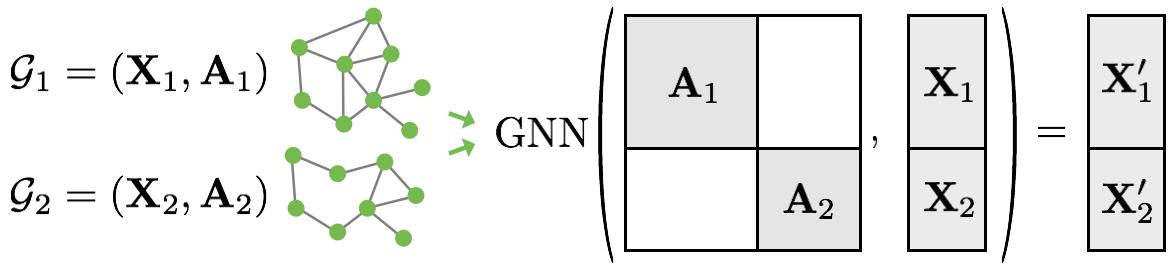 

Эта процедура имеет несколько важных преимуществ перед другими процедурами пакетной обработки:

1. Операторы GNN, которые используют схему передачи сообщений, не нуждаются в модификации, поскольку обмен сообщениями между двумя узлами, принадлежащими к разным графам, не осуществляется.

2. Нет никаких вычислительных или операционных затрат, поскольку матрицы смежности хранятся в плотной форме, содержащей только ненулевые элементы, т.е. ребра.

PyTorch Geometric автоматически распределяет выборки при группировании нескольких графов в один "гигантский" граф с использованием класса [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader`): 

In [16]:
from torch_geometric.loader import DataLoader

In [17]:
train_loader = DataLoader(train_dataset_si_cubic, batch_size=256, shuffle=True)

In [18]:
train_loader

In [19]:
test_loader = DataLoader(test_dataset_si_cubic, batch_size=228, shuffle=False)

In [20]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 256
DataBatch(x=[47360, 5], y=[256, 1], positions=[47360, 3], lattice_translational_vectors=[256, 9], edge_index_voronoi=[2, 181008], edge_attr_voronoi=[181008, 6], batch=[47360], ptr=[257])

Step 2:
Number of graphs in the current batch: 222
DataBatch(x=[43944, 5], y=[222, 1], positions=[43944, 3], lattice_translational_vectors=[222, 9], edge_index_voronoi=[2, 159680], edge_attr_voronoi=[159680, 6], batch=[43944], ptr=[223])



In [96]:
len(data.x)

39176

Мы подготовили данные. Подготовили саму структуру нейронной сети в виде отдельного класса и инициировали модель как экземпляр этого класса сообщив ему нужные гиперпараметры.
В качестве проверки работоспособности сообщили модели один тестовый пакет данных. Модель выдала результат в виде тензора. Соответственно, модель работает. Обучать модель будем в следующем шаге. 

#  Модель GCNPredictor

Простой вариант модели, которая учитывает признаки узлов и индексы связей. И всё. 

In [ ]:
# import torch
# import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNPredictor(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 1)  # 1 выход для регрессии
        
    def forward(self, data):
        # x, edge_index = data.x, data.edge_index
        x, edge_index = data.x, data.edge_index_voronoi
        batch = data.batch
        
        # 1. Графовые свертки
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index)
        
        # # 2. Глобальное усреднение (читаем весь граф)
        # x = torch.mean(x, dim=0, keepdim=True)

        
        #Пуллинг для каждого графа в батче в отдельности
        x = global_mean_pool(x, batch) # Размер: [num_graphs, hidden_channels]
        
        # 3. Полносвязный слой для предсказания
        return self.lin(x)

In [142]:
# создадим экземпляр модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_GCNPredictor = GCNPredictor(
    num_node_features=dataset_full_562_si_cubic[0].x.shape[1], # задаём размерность (количество признаков атомов) на первом примере
    hidden_channels=128 # зададим размерность скрытых слоёв
).to(device)

In [143]:
# зададим оптимизатор
optimizer = torch.optim.Adam(model_GCNPredictor.parameters(), lr=0.005)  # Было 0.01
# зададим функцию потерь
criterion = torch.nn.MSELoss()  # Для регрессии

In [144]:
def train():
    """
    Внутренняя функция для одной эпохи обучения.
    Возвращает суммарный лосс за эпоху.
    """
    # Переводим модель в режим обучения (важно для слоёв типа Dropout, BatchNorm)
    model_GCNPredictor.train()
    val_loss = 0  # Инициализируем переменную для накопления потерь

    # Итерируемся по батчам тренировочных данных
    for data in train_loader:
        # 1. Прямой проход (forward pass) - вычисление предсказаний модели
        out = model_GCNPredictor(data)

        # 2. Вычисление функции потерь между предсказаниями и истинными значениями
        loss = criterion(out, data['y'])

        # 3. Обратное распространение ошибки (backward pass) - вычисление градиентов
        loss.backward()

        # 4. Обновление параметров модели на основе вычисленных градиентов
        optimizer.step()

        # 5. Обнуление градиентов перед следующим батчем
        optimizer.zero_grad()

        # 6. Накопление лосса (detach() чтобы избежать накопления в вычислительном графе)
        val_loss += loss.detach().item()

    return val_loss  # Возвращаем суммарный лосс за эпоху

In [145]:
def test(loader):
    """
    Внутренняя функция для оценки модели на переданном загрузчике данных.
    Возвращает среднее значение R2-score по всем батчам.
    """
    # Переводим модель в режим оценки (отключаем Dropout и т.д.)
    model_GCNPredictor.eval()
    r2 = []  # Список для хранения R2-score по каждому батчу

    # Итерируемся по батчам данных (без вычисления градиентов)
    for data in loader:
        # Получаем предсказания модели
        out = model_GCNPredictor(data)

        # print('out', out)

        # Преобразуем предсказания и истинные значения в 1D массивы
        pred = out.detach().ravel()  # detach() чтобы не вычислять градиенты
        true = data['y'].ravel()

        # Вычисляем R2-score для текущего батча и сохраняем
        r2_calculate = r2_score(pred.numpy(), true.numpy())
        print('r2_calculate', r2_calculate)
        r2.append(r2_calculate)

    # Возвращаем среднее значение R2-score по всем батчам
    return np.array(r2).mean()

In [146]:
epochs = 150
# Основной цикл обучения
for epoch in range(1, epochs+1):
    # Одна эпоха обучения и получение лосса
    val_loss = train()
    
    # Вывод информации о текущей эпохе
    print(f'Epoch: {epoch:03d}, Val Loss: {val_loss:.4f}')

    # Каждые 10 эпох оцениваем модель на тренировочных и тестовых данных
    if epoch % 10 == 0:
        train_acc = test(train_loader)  # R2 на тренировочных данных
        print(f'Train R2: {train_acc:.4f}')
        test_acc = test(test_loader)  # R2 на тестовых данных
        print(f'Train R2: {train_acc:.4f}, Test R2: {test_acc:.4f}')

Epoch: 001, Val Loss: 167.8099
Epoch: 002, Val Loss: 44.4322
Epoch: 003, Val Loss: 137.4799
Epoch: 004, Val Loss: 26.3936
Epoch: 005, Val Loss: 18.2713
Epoch: 006, Val Loss: 44.5608
Epoch: 007, Val Loss: 28.4731
Epoch: 008, Val Loss: 7.1138
Epoch: 009, Val Loss: 3.9276
Epoch: 010, Val Loss: 10.5958
r2_calculate -4.7447829246521
r2_calculate -4.8038201332092285
Train R2: -4.7743
r2_calculate -4.5874714851379395
Train R2: -4.7743, Test R2: -4.5875
Epoch: 011, Val Loss: 13.8496
Epoch: 012, Val Loss: 10.6092
Epoch: 013, Val Loss: 5.4380
Epoch: 014, Val Loss: 2.7459
Epoch: 015, Val Loss: 2.7812
Epoch: 016, Val Loss: 4.0010
Epoch: 017, Val Loss: 4.8523
Epoch: 018, Val Loss: 4.6659
Epoch: 019, Val Loss: 3.8076
Epoch: 020, Val Loss: 2.9095
r2_calculate -15.648487091064453
r2_calculate -16.293882369995117
Train R2: -15.9712
r2_calculate -21.068387985229492
Train R2: -15.9712, Test R2: -21.0684
Epoch: 021, Val Loss: 2.4915
Epoch: 022, Val Loss: 2.4529
Epoch: 023, Val Loss: 2.6971
Epoch: 024, Val

Модель GCNPredictor явно не справилась, очень примитивная архитектура, которой недостаточно для обработки данных датасета.

# Улучшенная модель GCNPredictor_app_batchnorm

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNPredictor_app_batchnorm(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        """Инициализация модели GCN с Batch Normalization
        
        Args:
            num_node_features (int): Количество признаков у каждого узла графа
            hidden_channels (int): Размер скрытого представления (количество нейронов)
        """
        super().__init__()  # Инициализация родительского класса torch.nn.Module
        
        # Первый графовый сверточный слой (GCN)
        # Преобразует node_features -> hidden_channels
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        
        # Batch Normalization для первого слоя
        # Нормализует активации по hidden_channels измерениям
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        
        # Второй графовый сверточный слой
        # hidden_channels -> hidden_channels (сохраняет размерность)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # Batch Normalization для второго слоя
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        
        # Третий графовый сверточный слой (добавлен для увеличения глубины сети)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        
        # Финальный линейный слой для регрессии
        # Преобразует hidden_channels -> 1 (скалярное предсказание)
        self.lin = torch.nn.Linear(hidden_channels, 1)
        
    def forward(self, data):
        """Прямой проход данных через модель
        
        Args:
            data (Data): Объект данных из torch_geometric содержащий:
                - x: Матрица признаков узлов [num_nodes, num_node_features]
                - edge_index: Матрица связей графа [2, num_edges]
                - batch: Вектор, указывающий принадлежность узлов к графам в батче
                
        Returns:
            torch.Tensor: Предсказания модели [batch_size, 1]
        """
        # Извлекаем признаки узлов и информацию о связях
        x, edge_index = data.x, data.edge_index_voronoi
        
        # Вектор, указывающий к какому графу в батче принадлежит каждый узел
        batch = data.batch  
        
        # Первый блок: GCN -> BatchNorm -> ReLU -> Dropout
        x = self.conv1(x, edge_index)  # Применяем графовую свертку
        x = self.bn1(x)                # Нормализуем активации
        x = F.relu(x)                  # Применяем нелинейную функцию активации
        x = F.dropout(x, p=0.2,        # Регуляризация - случайное обнуление 20% нейронов
              training=self.training)  # (только в режиме обучения)
        
        # Второй блок: аналогично первому
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, 
              training=self.training)
        
        # Третий блок (только свертка без активации/нормализации)
        x = self.conv3(x, edge_index)
        
        # Глобальный усредняющий пуллинг (объединяем узлы каждого графа)
        # Результат: [num_graphs_in_batch, hidden_channels]
        x = global_mean_pool(x, batch)  
        
        # Финальное линейное преобразование в скалярное значение
        # Возвращаем [num_graphs_in_batch, 1]
        return self.lin(x)  

Ключевые особенности архитектуры:

1. **Трехслойная GCN структура**:
   - Два слоя с активацией и нормализацией
   - Один финальный слой без активации (чтобы не ограничивать выход)

2. **Batch Normalization**:
   - Стабилизирует распределение активаций между слоями
   - Позволяет использовать большие learning rates
   - Добавляет небольшой регуляризирующий эффект

3. **Dropout (p=0.2)**:
   - Предотвращает переобучение
   - Отключается автоматически в режиме eval()

4. **Глобальный пуллинг**:
   - Объединяет информацию от всех узлов графа
   - Делает модель инвариантной к размеру графа

5. **Финальный линейный слой**:
   - Преобразует скрытое представление в скалярную величину
   - Подходит для задач регрессии

Эта архитектура хорошо подходит для задач предсказания свойств материалов по их графовой структуре, так как:
- Учитывает локальные и глобальные зависимости в графе
- Устойчива к разным размерам графов в батче
- Имеет механизмы против переобучения

In [184]:
# создадим экземпляр модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_GCNPredictor_app_batchnorm = GCNPredictor_app_batchnorm(
    num_node_features=data_graph_example.num_node_features,
    hidden_channels=16
).to(device)

In [185]:
# зададим оптимизатор
optimizer = torch.optim.Adam(model_GCNPredictor_app_batchnorm.parameters(), lr=0.005)  # Было 0.01
# зададим функцию потерь
criterion = torch.nn.MSELoss()  # Для регрессии

In [186]:
def train():
    """
    Внутренняя функция для одной эпохи обучения.
    Возвращает суммарный лосс за эпоху.
    """
    # Переводим модель в режим обучения (важно для слоёв типа Dropout, BatchNorm)
    model_GCNPredictor_app_batchnorm.train()
    val_loss = 0  # Инициализируем переменную для накопления потерь

    # Итерируемся по батчам тренировочных данных
    for data in train_loader:
        # 1. Прямой проход (forward pass) - вычисление предсказаний модели
        out = model_GCNPredictor_app_batchnorm(data)

        # 2. Вычисление функции потерь между предсказаниями и истинными значениями
        loss = criterion(out, data['y'])

        # 3. Обратное распространение ошибки (backward pass) - вычисление градиентов
        loss.backward()

        # 4. Обновление параметров модели на основе вычисленных градиентов
        optimizer.step()

        # 5. Обнуление градиентов перед следующим батчем
        optimizer.zero_grad()

        # 6. Накопление лосса (detach() чтобы избежать накопления в вычислительном графе)
        val_loss += loss.detach().item()

    return val_loss  # Возвращаем суммарный лосс за эпоху

def test(loader):
    """
    Внутренняя функция для оценки модели на переданном загрузчике данных.
    Возвращает среднее значение R2-score по всем батчам.
    """
    # Переводим модель в режим оценки (отключаем Dropout и т.д.)
    model_GCNPredictor_app_batchnorm.eval()
    r2 = []  # Список для хранения R2-score по каждому батчу

    # Итерируемся по батчам данных (без вычисления градиентов)
    for data in loader:
        # Получаем предсказания модели
        out = model_GCNPredictor_app_batchnorm(data)

        # Преобразуем предсказания и истинные значения в 1D массивы
        pred = out.detach().ravel()  # detach() чтобы не вычислять градиенты
        true = data['y'].ravel()

        # Вычисляем R2-score для текущего батча и сохраняем
        r2.append(r2_score(pred.numpy(), true.numpy()))

    # Возвращаем среднее значение R2-score по всем батчам
    return np.array(r2).mean()

In [187]:
# можно запускать данных код несколько раз, имея ввиду, что каждый запуск это 50 эпох
epochs = 250
# Основной цикл обучения
for epoch in range(1, epochs+1):
    # Одна эпоха обучения и получение потерь
    val_loss = train()
    
    # Вывод информации о текущей эпохе
    print(f'Epoch: {epoch:03d}, Val Loss: {val_loss:.4f}')

    # Каждые 10 эпох оцениваем модель на тренировочных и тестовых данных
    if epoch % 10 == 0:
        train_acc = test(train_loader)  # R2 на тренировочных данных
        print(f'Train R2: {train_acc:.4f}')
        test_acc = test(test_loader)  # R2 на тестовых данных
        print(f'Train R2: {train_acc:.4f}, Test R2: {test_acc:.4f}')

Epoch: 001, Val Loss: 4.9610
Epoch: 002, Val Loss: 3.7341
Epoch: 003, Val Loss: 2.9853
Epoch: 004, Val Loss: 2.7118
Epoch: 005, Val Loss: 2.6669
Epoch: 006, Val Loss: 2.5489
Epoch: 007, Val Loss: 2.5203
Epoch: 008, Val Loss: 2.3750
Epoch: 009, Val Loss: 2.3400
Epoch: 010, Val Loss: 2.2666
Train R2: -13.5197
Train R2: -13.5197, Test R2: -14.8771
Epoch: 011, Val Loss: 2.1772
Epoch: 012, Val Loss: 2.1075
Epoch: 013, Val Loss: 2.0803
Epoch: 014, Val Loss: 2.0385
Epoch: 015, Val Loss: 1.9797
Epoch: 016, Val Loss: 1.9389
Epoch: 017, Val Loss: 1.9404
Epoch: 018, Val Loss: 1.9375
Epoch: 019, Val Loss: 1.8604
Epoch: 020, Val Loss: 1.8197
Train R2: -2.3731
Train R2: -2.3731, Test R2: -2.6463
Epoch: 021, Val Loss: 1.7234
Epoch: 022, Val Loss: 1.8209
Epoch: 023, Val Loss: 1.7894
Epoch: 024, Val Loss: 1.5938
Epoch: 025, Val Loss: 1.6362
Epoch: 026, Val Loss: 1.5976
Epoch: 027, Val Loss: 1.5864
Epoch: 028, Val Loss: 1.4697
Epoch: 029, Val Loss: 1.4622
Epoch: 030, Val Loss: 1.6138
Train R2: -1.0112
T

Получили посредственный результат R2=65%. Но для данной модели результат намного лучше чем для самой простой модели В данной модели GCNPredictor_app_batchnorm добавлены дополнительные свёрточные слои, а также нормализация и регуляризация (случайное обнуление 20% нейронов)

# Улучшенная модель GCN_Predictor_for_full_data

В данном случае мы составим самый простой вариант, но необходимо чтобы модель учитывала данные признаков связей.

In [222]:
data_graph_example

Data(x=[288, 5], y=[1, 1], positions=[288, 3], lattice_translational_vectors=[1, 9], edge_index_voronoi=[2, 864], edge_attr_voronoi=[864, 6])

In [165]:
# Модель возвращает теперь Не одно значение,исправили исправить
# import torch
# import torch.nn.functional as F
from torch_geometric.nn import GCNConv
class GCN_Predictor_for_full_data(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.edge_encoder = torch.nn.Linear(num_edge_features, hidden_channels) # линейный слой на входе количество признаков рёбер,
        # на выходе размер скрытого пространства признаков
        self.lin = torch.nn.Linear(hidden_channels, 1)  # 1 выход для регрессии
        
    def forward(self, data):
        x = data.x
        edge_index = data.edge_index_voronoi
        edge_attr = data.edge_attr_voronoi

        batch = data.batch
        

        # 1. Графовые свертки
        x = self.conv1(x, edge_index)
        # x = self.conv1(x, edge_index, edge_attr)
        # x = self.conv1(x, edge_index).relu()
        
        x = F.relu(x)


        # Кодирование признаков ребер
        adge_embedding = self.edge_encoder(edge_attr)

        # Учёт edge_attr через поэлементное умножение
        x = x * adge_embedding.mean(dim=0) # Упрощённый вариант

        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        
        # 2. Глобальное усреднение (читаем весь граф)
        # x = torch.mean(x, dim=0, keepdim=True) # в этом усреднении была ошибка, возвращалось только одно значение.

        #Пуллинг для каждого графа в батче в отдельности
        x = global_mean_pool(x, batch) # Размер: [num_graphs, hidden_channels]
        
        # 3. Полносвязный слой для предсказания
        return self.lin(x) # Размер: [num_graphs]

### Пробуем обучить модель на одном примере 

In [111]:
# создадим экземпляр модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_GCN_Predictor_for_full_data = GCN_Predictor_for_full_data(
    num_node_features=data_graph_example.num_node_features,
    # num_edge_features = data_graph_example.num_edge_features,
    num_edge_features = data_graph_example.edge_attr_voronoi.shape[1],
    hidden_channels=16
).to(device)

In [112]:
# смотрим параметры модели
model_GCN_Predictor_for_full_data

GCN_Predictor_for_full_data(
  (conv1): GCNConv(5, 16)
  (conv2): GCNConv(16, 16)
  (edge_encoder): Linear(in_features=6, out_features=16, bias=True)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)

In [113]:
# зададим оптимизатор
optimizer = torch.optim.Adam(model_GCN_Predictor_for_full_data.parameters(), lr=0.001)  # Было 0.01
# зададим функцию потерь
criterion = torch.nn.MSELoss()  # Для регрессии

In [114]:
def train_model_GCN_Predictor_for_full_data():
    """Функция для одного шага обучения"""
    model_GCN_Predictor_for_full_data.train()  # Переводим модель в режим обучения (важно для dropout/batch norm)
    optimizer.zero_grad()  # Обнуляем градиенты с предыдущего шага
    
    # Прямой проход (forward pass) - получаем предсказания модели
    out = model_GCN_Predictor_for_full_data(data_graph_example)
    
    # Вычисляем значение функции потерь между предсказаниями и истинными значениями
    loss = criterion(out, data_graph_example.y)
    
    # Обратный проход (backward pass) - вычисляем градиенты
    loss.backward()
    
    # Обновляем веса модели согласно вычисленным градиентам
    optimizer.step()
    
    # Возвращаем значение функции потерь для мониторинга
    return loss.item()

In [115]:
for epoch in range(50):
    loss = train_model_GCN_Predictor_for_full_data()
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 31.3610
Epoch 2, Loss: 25.4041
Epoch 3, Loss: 19.6859
Epoch 4, Loss: 16.4011
Epoch 5, Loss: 6.5334
Epoch 6, Loss: 5.9687
Epoch 7, Loss: 3.7953
Epoch 8, Loss: 2.1564
Epoch 9, Loss: 0.5689
Epoch 10, Loss: 0.2987
Epoch 11, Loss: 1.1728
Epoch 12, Loss: 0.6268
Epoch 13, Loss: 2.6710
Epoch 14, Loss: 3.6839
Epoch 15, Loss: 1.7319
Epoch 16, Loss: 4.9517
Epoch 17, Loss: 0.7242
Epoch 18, Loss: 1.6165
Epoch 19, Loss: 3.3945
Epoch 20, Loss: 3.7701
Epoch 21, Loss: 0.8067
Epoch 22, Loss: 2.2818
Epoch 23, Loss: 0.5340
Epoch 24, Loss: 0.4132
Epoch 25, Loss: 2.5047
Epoch 26, Loss: 0.0070
Epoch 27, Loss: 0.1716
Epoch 28, Loss: 0.1100
Epoch 29, Loss: 0.6856
Epoch 30, Loss: 0.0794
Epoch 31, Loss: 0.0003
Epoch 32, Loss: 0.1356
Epoch 33, Loss: 0.0365
Epoch 34, Loss: 0.0333
Epoch 35, Loss: 0.0055
Epoch 36, Loss: 0.0157
Epoch 37, Loss: 1.1242
Epoch 38, Loss: 0.3700
Epoch 39, Loss: 0.1565
Epoch 40, Loss: 1.1978
Epoch 41, Loss: 0.5637
Epoch 42, Loss: 0.1204
Epoch 43, Loss: 0.9266
Epoch 44, Loss: 

In [116]:
out_GCN_Predictor_for_full_data = model_GCN_Predictor_for_full_data(data_graph_example)
out_GCN_Predictor_for_full_data

tensor(-3.0091, grad_fn=<SqueezeBackward0>)

In [117]:
# берем самый первый батч - пакет данных в одном графе. В данном случае тестовый батч единственный) 
first_batch = [i for i in test_loader][0]

In [118]:
# смотрим структуру пакета данных
first_batch

DataBatch(x=[18136, 5], y=[84, 1], positions=[18136, 3], lattice_translational_vectors=[84, 9], edge_index_voronoi=[2, 63416], edge_attr_voronoi=[63416, 6], batch=[18136], ptr=[85])

In [119]:
# вот тот момент, когда на вход подается челый пакет данных, а на выходе только одно число в тензоре
model_GCN_Predictor_for_full_data(first_batch)

tensor([ -5.2117,  -1.2861,  -4.7707,  -3.5145,  -1.6561,  -3.0677,  -3.0942,
         -0.4991, -12.2021, -10.9259,  -7.0279, -10.4723,  -1.6462,   1.6203,
         -1.7361,  -8.5794,  -0.7785,  -1.5053,  -0.8417,  -1.4877,  -1.4812,
         -1.4584,  -1.6165,  -1.6841,  -4.2086,  -6.8170,  -6.5765,  -6.2306,
         -4.2047,  -1.9435,  -4.7149,  -0.1280,  -4.7275,  -6.0523,  -2.1624,
         -1.4877,  -1.2204,  -2.2281,  -3.5326,  -4.4548,   1.5559,  -2.8993,
         -5.7020,  -3.3545,  -1.7175, -10.1336,  -0.7211,  -8.8400,  -5.2321,
         -9.0394,  -0.7366,  -4.8869,  -5.3592,  -4.0037,  -0.7586,  -6.3598,
         -4.2547,  -3.8927,  -1.9431,  -2.1552,  -3.6527,  -4.6308,  -3.8604,
         -4.4229,  -3.1149,  -0.0232,  -3.0204,  -2.1383,  -1.4044,  -4.2940,
         -2.8871,  -0.0226,  -6.1442,  -5.1578,  -8.7699, -11.9468,  -5.9226,
         -7.7979,  -2.0192,  -8.2339,  -1.5347,  -4.7801,  -2.3512,  -4.6455],
       grad_fn=<SqueezeBackward0>)

### Запускаем обучение на полных данных train

In [166]:
# создадим экземпляр модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_GCN_Predictor_for_full_data = GCN_Predictor_for_full_data(
    num_node_features=data_graph_example.num_node_features,
    # num_edge_features = data_graph_example.num_edge_features,
    num_edge_features = data_graph_example.edge_attr_voronoi.shape[1],
    hidden_channels=16
).to(device)

In [154]:
model_GCN_Predictor_for_full_data

GCN_Predictor_for_full_data(
  (conv1): GCNConv(5, 16)
  (conv2): GCNConv(16, 16)
  (edge_encoder): Linear(in_features=6, out_features=16, bias=True)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)

In [167]:
# зададим оптимизатор
optimizer = torch.optim.Adam(model_GCN_Predictor_for_full_data.parameters(), lr=0.005)  # Было 0.01
# зададим функцию потерь
criterion = torch.nn.MSELoss()  # Для регрессии

In [168]:
def train():
    """
    Внутренняя функция для одной эпохи обучения.
    Возвращает суммарный лосс за эпоху.
    """
    # Переводим модель в режим обучения (важно для слоёв типа Dropout, BatchNorm)
    model_GCN_Predictor_for_full_data.train()
    val_loss = 0  # Инициализируем переменную для накопления потерь

    # Итерируемся по батчам тренировочных данных
    for data in train_loader:
        # 1. Прямой проход (forward pass) - вычисление предсказаний модели
        out = model_GCN_Predictor_for_full_data(data)

        # 2. Вычисление функции потерь между предсказаниями и истинными значениями
        loss = criterion(out, data['y'])

        # 3. Обратное распространение ошибки (backward pass) - вычисление градиентов
        loss.backward()

        # 4. Обновление параметров модели на основе вычисленных градиентов
        optimizer.step()

        # 5. Обнуление градиентов перед следующим батчем
        optimizer.zero_grad()

        # 6. Накопление лосса (detach() чтобы избежать накопления в вычислительном графе)
        val_loss += loss.detach().item()

    return val_loss  # Возвращаем суммарный лосс за эпоху

In [169]:
def test(loader):
    """
    Внутренняя функция для оценки модели на переданном загрузчике данных.
    Возвращает среднее значение R2-score по всем батчам.
    """
    # Переводим модель в режим оценки (отключаем Dropout и т.д.)
    model_GCN_Predictor_for_full_data.eval()
    r2 = []  # Список для хранения R2-score по каждому батчу

    # Итерируемся по батчам данных (без вычисления градиентов)
    for data in loader:
        # Получаем предсказания модели
        out = model_GCN_Predictor_for_full_data(data)

        # Преобразуем предсказания и истинные значения в 1D массивы
        pred = out.detach().ravel()  # detach() чтобы не вычислять градиенты
        true = data['y'].ravel()

        # Вычисляем R2-score для текущего батча и сохраняем
        r2.append(r2_score(pred.numpy(), true.numpy()))

    # Возвращаем среднее значение R2-score по всем батчам
    return np.array(r2).mean()

In [96]:
test_loader

In [ ]:
# можно запускать данных код несколько раз, имея ввиду, что каждый запуск это 50 эпох
epochs = 50
# Основной цикл обучения
for epoch in range(1, epochs+1):
    # Одна эпоха обучения и получение лосса
    val_loss = train()
    
    # Вывод информации о текущей эпохе
    print(f'Epoch: {epoch:03d}, Val Loss: {val_loss:.4f}')

    # Каждые 10 эпох оцениваем модель на тренировочных и тестовых данных
    if epoch % 10 == 0:
        train_acc = test(train_loader)  # R2 на тренировочных данных
        print(f'Train R2: {train_acc:.4f}')
        test_acc = test(test_loader)  # R2 на тестовых данных
        print(f'Train R2: {train_acc:.4f}, Test R2: {test_acc:.4f}')

Epoch: 001, Val Loss: 0.9827
Epoch: 002, Val Loss: 0.9894
Epoch: 003, Val Loss: 0.9702
Epoch: 004, Val Loss: 0.9784
Epoch: 005, Val Loss: 0.9955
Epoch: 006, Val Loss: 1.0063
Epoch: 007, Val Loss: 0.9981
Epoch: 008, Val Loss: 1.0049
Epoch: 009, Val Loss: 0.9618
Epoch: 010, Val Loss: 0.9822
Train R2: 0.2865
Train R2: 0.2865, Test R2: 0.2840
Epoch: 011, Val Loss: 1.0044
Epoch: 012, Val Loss: 0.9696
Epoch: 013, Val Loss: 0.9639
Epoch: 014, Val Loss: 0.9680
Epoch: 015, Val Loss: 0.9628
Epoch: 016, Val Loss: 0.9733
Epoch: 017, Val Loss: 0.9870
Epoch: 018, Val Loss: 0.9602
Epoch: 019, Val Loss: 0.9635
Epoch: 020, Val Loss: 0.9689
Train R2: 0.2277
Train R2: 0.2277, Test R2: 0.2466
Epoch: 021, Val Loss: 0.9751
Epoch: 022, Val Loss: 0.9874
Epoch: 023, Val Loss: 1.0044
Epoch: 024, Val Loss: 0.9826
Epoch: 025, Val Loss: 0.9656
Epoch: 026, Val Loss: 0.9626
Epoch: 027, Val Loss: 0.9778
Epoch: 028, Val Loss: 0.9624
Epoch: 029, Val Loss: 0.9794
Epoch: 030, Val Loss: 0.9709
Train R2: 0.2366
Train R2: 0

Результат очень низкий R2=22%. Архитектура модели явно недостаточна для качественной обработки представленного датасета.

# Традиционная модель GCN

Данная модель предоставлена моим Куратором, использую её как эталонный вариант.

In [78]:
# тоже самое, но уже с комментариями

class GCN(torch.nn.Module):
    """
    Графовая нейронная сеть (GNN) для предсказания свойств материалов.
    Сочетает структурную информацию (атомы и их связи) с параметрами кристаллической решётки.
    
    Параметры:
        hyperparameters (dict): Словарь с гиперпараметрами модели, включая:
            - hidden_embeding (int): Размер скрытого векторного пространства.
    """
    def __init__(self, num_node_features, num_edge_features, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)  # Фиксируем случайное начальное состояние для воспроизводимости

        # 1. Инициализация гиперпараметров
        # self.hidden_embeding = hidden_channels

        # 2. Слои для обработки структурных данных (атомы и их связи)
        # PointTransformerConv - графовый слой, учитывающий позиции атомов
        self.structural_embedding = PointTransformerConv(
            in_channels=num_node_features,  # Количество признаков узла (например, 5)
            out_channels=hidden_channels      # Размер выходного эмбеддинга
        )

        # 3. Слой для обработки параметров решётки
        # Линейный слой преобразует 9 параметров решётки (3x3 матрица) в скрытое пространство
        self.lattice_embedding = nn.Linear(9, hidden_channels)

        # 4. Скрытые полносвязные слои для комбинирования признаков
        self.hidden_layers = nn.Sequential(
            # Первый слой: объединяет структурные и решёточные признаки
            Linear(hidden_channels * 2, hidden_channels * 3),
            nn.ReLU(inplace=True),  # Функция активации
            # Второй слой: сжатие признаков
            Linear(hidden_channels * 3, hidden_channels * 2),
            nn.ReLU(inplace=True),
            # Третий слой: подготовка к выходному слою
            Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(inplace=True)
        )

        # 5. Выходной слой (регрессия)
        self.out = Linear(hidden_channels, 1)  # Предсказывает 1 значение (например, энергию)

    def forward(self, data):
        """
        Проход данных через модель.
        
        Параметры:
            data (torch_geometric.data.Data): Граф с полями:
                - x: Признаки узлов [num_nodes, num_features]
                - pos: Координаты атомов [num_nodes, 3]
                - edge_index: Индексы связей [2, num_edges]
                - lattice: Параметры решётки [batch_size, 9]
                - batch: Вектор батча [num_nodes]
                
        Возвращает:
            torch.Tensor: Предсказанное значение [batch_size, 1]
        """
        # 1. Структурный эмбеддинг (атомы + связи)
        # PointTransformerConv учитывает позиции атомов (data.pos) и связи (data.edge_index)
        x = self.structural_embedding(data.x, data.positions, data.edge_index_voronoi)  # [num_nodes, hidden_embeding]

        # 2. Усреднение по графу (pooling)
        # Преобразует эмбеддинги узлов в один вектор на граф
        x = global_mean_pool(x, data.batch)  # [batch_size, hidden_embeding]

        # 3. Эмбеддинг решётки
        l = self.lattice_embedding(data.lattice_translational_vectors)  # [batch_size, hidden_embeding]

        # 4. Объединение структурных и решёточных признаков
        x = torch.hstack([x, l])  # [batch_size, hidden_embeding * 2]

        # 5. Обработка через скрытые слои
        x = self.hidden_layers(x)  # [batch_size, hidden_embeding]

        # 6. Выходной слой
        x = self.out(x)  # [batch_size, 1]

        return x

## Применяем на одном батче

In [168]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# создадим экземпляр модели
model_GCN = GCN(
    num_node_features=data_graph_example.num_node_features,
    num_edge_features = data_graph_example.edge_attr_voronoi.shape[1],
    hidden_channels=16
).to('cpu')

In [156]:
model_GCN(first_batch)

tensor([[-0.2712],
        [-0.4001],
        [-0.4786],
        [-0.3810],
        [-0.1240],
        [-0.4489],
        [-0.2244],
        [-0.3229],
        [-0.7172],
        [-0.3492],
        [-0.4748],
        [-0.6601],
        [-0.4482],
        [-0.2187],
        [-0.3634],
        [-0.7061],
        [-0.3546],
        [ 0.0450],
        [-0.2249],
        [ 0.0272],
        [ 0.0474],
        [-0.5950],
        [ 0.0634],
        [-0.7954],
        [-0.3952],
        [-0.6736],
        [-0.7344],
        [-0.5444],
        [-0.4743],
        [-0.3766],
        [-0.4123],
        [-0.4009],
        [-0.2933],
        [-0.2788],
        [-0.2715],
        [-0.4109],
        [-0.2592],
        [-0.2887],
        [-0.2388],
        [-0.5931],
        [-0.5120],
        [-0.5625],
        [-0.7395],
        [-0.9393],
        [-0.4306],
        [-0.7041],
        [-0.3698],
        [-0.7028],
        [-0.4909],
        [-0.3986],
        [-0.1121],
        [-0.6568],
        [-0.

## Запускаем на полных данных

In [79]:
def train_GCN():
    """
    Внутренняя функция для одной эпохи обучения.
    Возвращает суммарный лосс за эпоху.
    """
    # Переводим модель в режим обучения (важно для слоёв типа Dropout, BatchNorm)
    model_GCN.train()
    val_loss = 0  # Инициализируем переменную для накопления потерь

    # Итерируемся по батчам тренировочных данных
    for data in train_loader:
        # 1. Прямой проход (forward pass) - вычисление предсказаний модели
        out = model_GCN(data)

        # 2. Вычисление функции потерь между предсказаниями и истинными значениями
        loss = criterion(out, data['y'])

        # 3. Обратное распространение ошибки (backward pass) - вычисление градиентов
        loss.backward()

        # 4. Обновление параметров модели на основе вычисленных градиентов
        optimizer.step()

        # 5. Обнуление градиентов перед следующим батчем
        optimizer.zero_grad()

        # 6. Накопление loss(detach() чтобы избежать накопления в вычислительном графе)
        val_loss += loss.detach().item()

    return val_loss  # Возвращаем суммарный лосс за эпоху

In [80]:
def test_GCN(loader):
    """
    Внутренняя функция для оценки модели на переданном загрузчике данных.
    Возвращает среднее значение R2-score по всем батчам.
    """
    # Переводим модель в режим оценки (отключаем Dropout и т.д.)
    model_GCN.eval()
    r2 = []  # Список для хранения R2-score по каждому батчу

    # Итерируемся по батчам данных (без вычисления градиентов)
    for data in loader:
        # Получаем предсказания модели
        out = model_GCN(data)

        # Преобразуем предсказания и истинные значения в 1D массивы
        pred = out.detach().ravel()  # detach() чтобы не вычислять градиенты
        true = data['y'].ravel()

        # Вычисляем R2-score для текущего батча и сохраняем
        r2.append(r2_score(pred.numpy(), true.numpy()))

    # Возвращаем среднее значение R2-score по всем батчам
    return np.array(r2).mean()

In [81]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# создадим экземпляр модели
model_GCN = GCN(
    num_node_features=data_graph_example.num_node_features,
    num_edge_features = data_graph_example.edge_attr_voronoi.shape[1],
    hidden_channels=128
).to('cpu')

# зададим оптимизатор
optimizer = torch.optim.Adam(model_GCN.parameters(), lr=0.01)  # Было 0.01
# зададим функцию потерь
criterion = torch.nn.MSELoss()  # Для регрессии

In [82]:
epochs = 150
# Основной цикл обучения
for epoch in range(1, epochs+1):
    # Одна эпоха обучения и получение лосса
    val_loss = train_GCN()
    
    # Вывод информации о текущей эпохе
    print(f'Epoch: {epoch:03d}, Val Loss: {val_loss:.4f}')

    # Каждые 10 эпох оцениваем модель на тренировочных и тестовых данных
    if epoch % 10 == 0:
        train_acc = test_GCN(train_loader) # R2 на тренировочных данных
        print(f'Train R2: {train_acc:.4f}')
        test_acc = test_GCN(test_loader) # R2 на тестовых данных
        print(f'Train R2: {train_acc:.4f}, Test R2: {test_acc:.4f}')

Epoch: 001, Val Loss: 5856.8751
Epoch: 002, Val Loss: 7.9261
Epoch: 003, Val Loss: 4.8384
Epoch: 004, Val Loss: 2.7324
Epoch: 005, Val Loss: 2.2283
Epoch: 006, Val Loss: 2.1546
Epoch: 007, Val Loss: 1.8108
Epoch: 008, Val Loss: 1.7942
Epoch: 009, Val Loss: 1.6618
Epoch: 010, Val Loss: 1.6212
Train R2: -1.1472
Train R2: -1.1472, Test R2: -1.6172
Epoch: 011, Val Loss: 1.5112
Epoch: 012, Val Loss: 1.4338
Epoch: 013, Val Loss: 1.3375
Epoch: 014, Val Loss: 1.2685
Epoch: 015, Val Loss: 1.0518
Epoch: 016, Val Loss: 0.8864
Epoch: 017, Val Loss: 0.8508
Epoch: 018, Val Loss: 0.7621
Epoch: 019, Val Loss: 0.7504
Epoch: 020, Val Loss: 0.7360
Train R2: 0.4293
Train R2: 0.4293, Test R2: 0.4115
Epoch: 021, Val Loss: 0.7638
Epoch: 022, Val Loss: 0.7766
Epoch: 023, Val Loss: 0.7073
Epoch: 024, Val Loss: 0.6120
Epoch: 025, Val Loss: 0.6376
Epoch: 026, Val Loss: 0.5412
Epoch: 027, Val Loss: 0.5482
Epoch: 028, Val Loss: 0.4932
Epoch: 029, Val Loss: 0.4871
Epoch: 030, Val Loss: 0.4743
Train R2: 0.7345
Train

Вывод по разделу применения традиционной модели GCN для новой структуры графов в нашем датасете.  
Проверили как традиционная модель работает с новой структурой графов. Результат получили посредственный (Test R2 = 0.71), но задача была в том, чтобы модель просто сработала при новой структуре данных. В работе использован не самый удачный датасет для примера. Поэтому задача получить высокий показатель R2 в данном варианте не актуальна. 


# Доработанная модель CrystalGNN (использует все данные графа)

Задача новой модели - использовать все данные в структуре графа.

модель должна учитывать **все доступные данные графа** (узлы, рёбра, их атрибуты, позиции атомов и трансляционные вектора решётки)

In [188]:
from torch_geometric.utils import scatter

In [199]:
class CrystalGNN(torch.nn.Module):
    def __init__(self, num_node_features=5, hidden_channels=128):
        super().__init__()
        
        # Энкодер для узлов (атомов)
        self.node_encoder = torch.nn.Linear(num_node_features, hidden_channels)
        
        # Энкодер для рёбер (химических связей)
        self.edge_encoder = torch.nn.Linear(6, hidden_channels)  # edge_attr_voronoi dim=6
        
        # Энкодер для трансляционных векторов решётки
        self.lattice_encoder = torch.nn.Linear(9, hidden_channels)
        
        # Графовые слои с учётом геометрии
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # Внимание к позициям атомов
        self.pos_attention = torch.nn.Linear(3, 1)  # positions [x,y,z] -> внимание
        
        # Финальные слои
        self.lin1 = torch.nn.Linear(hidden_channels * 2, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)
        
        # Нормализация
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)

    def forward(self, data):
        # 1. Кодируем узлы (атомы)
        x = self.node_encoder(data.x)  # [num_nodes, hidden]
        
        # 2. Кодируем рёбра
        edge_attr = self.edge_encoder(data.edge_attr_voronoi)  # [num_edges, hidden]

        # Включаем атрибуты рёбер через узлы (суммируем информацию от соседей)
        x = x + scatter(edge_attr, data.edge_index_voronoi[1], dim=0, dim_size=x.size(0))

                # 5. Графовые свертки с передачей атрибутов рёбер
        x = self.conv1(x, data.edge_index_voronoi)
        x = self.bn1(x)
        x = F.elu(x)
        
        # 3. Кодируем трансляционные вектора решётки
        lattice = self.lattice_encoder(data.lattice_translational_vectors)  # [1, hidden]
        
        # 4. Механизм внимания на основе позиций атомов
        pos_weights = torch.sigmoid(self.pos_attention(data.positions))  # [num_nodes, 1]
        x = x * pos_weights  # Взвешиваем признаки по позициям
        
        # # 5. Графовые свертки с передачей атрибутов рёбер
        # x = self.conv1(x, data.edge_index_voronoi)
        # x = self.bn1(x)
        # x = F.elu(x)
        
        x = self.conv2(x, data.edge_index_voronoi)
        x = self.bn2(x)
        x = F.elu(x)
        
        # 6. Глобальный пуллинг с учётом решётки
        x_global = scatter(x, data.batch, dim=0, reduce='mean')  # [batch_size, hidden]
        x_global = torch.cat([x_global, lattice.expand(x_global.size(0), -1)], dim=1)
        
        # 7. Финальные слои
        x = F.elu(self.lin1(x_global))
        # return self.lin2(x).squeeze(-1)
        return self.lin2(x)

In [196]:
data

DataBatch(x=[43944, 5], y=[222, 1], positions=[43944, 3], lattice_translational_vectors=[222, 9], edge_index_voronoi=[2, 159680], edge_attr_voronoi=[159680, 6], batch=[43944], ptr=[223])

In [ ]:
# edge_encoder = torch.nn.Linear(6, 16)

In [ ]:
# edge_attr = edge_encoder(data.edge_attr_voronoi)  # [num_edges, hidden]

2. Ключевые улучшения:

1. **Кодирование всех компонентов**:
   - Узлы (`node_encoder`): Учитывает 5 атомных признаков
   - Рёбра (`edge_encoder`): Обрабатывает 6 признаков связей
   - Кристаллическая решётка (`lattice_encoder`): Учитывает 9D вектора трансляции

2. **Геометрическое внимание**:
   - Позиции атомов (`pos_attention`) влияют на важность узлов

3. **Улучшенные графовые слои**:
   - Передача атрибутов рёбер в свертки
   - ELU активация для лучшего обучения глубоких сетей

4. **Глобальная агрегация**:
   - Комбинирование информации от узлов и кристаллической решётки

In [213]:
# создадим экземпляр модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_CrystalGNN = CrystalGNN(
    num_node_features=data_graph_example.num_node_features,
    # num_edge_features = data_graph_example.num_edge_features,
    # num_edge_features = data_graph_example.edge_attr_voronoi.shape[1],
    hidden_channels=16
).to(device)

In [214]:
# зададим оптимизатор
optimizer = torch.optim.Adam(model_CrystalGNN.parameters(), lr=0.005)  # Было 0.01
# зададим функцию потерь
criterion = torch.nn.MSELoss()  # Для регрессии

In [215]:
def train():
    """
    Внутренняя функция для одной эпохи обучения.
    Возвращает суммарный лосс за эпоху.
    """
    # Переводим модель в режим обучения (важно для слоёв типа Dropout, BatchNorm)
    model_CrystalGNN.train()
    val_loss = 0  # Инициализируем переменную для накопления потерь

    # Итерируемся по батчам тренировочных данных
    for data in train_loader:
        # 1. Прямой проход (forward pass) - вычисление предсказаний модели
        out = model_CrystalGNN(data)

        # 2. Вычисление функции потерь между предсказаниями и истинными значениями
        loss = criterion(out, data['y'])

        # 3. Обратное распространение ошибки (backward pass) - вычисление градиентов
        loss.backward()

        # 4. Обновление параметров модели на основе вычисленных градиентов
        optimizer.step()

        # 5. Обнуление градиентов перед следующим батчем
        optimizer.zero_grad()

        # 6. Накопление лосса (detach() чтобы избежать накопления в вычислительном графе)
        val_loss += loss.detach().item()

    return val_loss  # Возвращаем суммарный лосс за эпоху

def test(loader):
    """
    Внутренняя функция для оценки модели на переданном загрузчике данных.
    Возвращает среднее значение R2-score по всем батчам.
    """
    # Переводим модель в режим оценки (отключаем Dropout и т.д.)
    model_CrystalGNN.eval()
    r2 = []  # Список для хранения R2-score по каждому батчу

    # Итерируемся по батчам данных (без вычисления градиентов)
    for data in loader:
        # Получаем предсказания модели
        out = model_CrystalGNN(data)

        # Преобразуем предсказания и истинные значения в 1D массивы
        pred = out.detach().ravel()  # detach() чтобы не вычислять градиенты
        true = data['y'].ravel()

        # Вычисляем R2-score для текущего батча и сохраняем
        r2.append(r2_score(pred.numpy(), true.numpy()))

    # Возвращаем среднее значение R2-score по всем батчам
    return np.array(r2).mean()


In [216]:

# можно запускать данных код несколько раз, имея ввиду, что каждый запуск это 50 эпох
epochs = 200
# Основной цикл обучения
for epoch in range(1, epochs+1):
    # Одна эпоха обучения и получение лосса
    val_loss = train()
    
    # Вывод информации о текущей эпохе
    print(f'Epoch: {epoch:03d}, Val Loss: {val_loss:.4f}')

    # Каждые 10 эпох оцениваем модель на тренировочных и тестовых данных
    if epoch % 10 == 0:
        train_acc = test(train_loader)  # R2 на тренировочных данных
        print(f'Train R2: {train_acc:.4f}')
        test_acc = test(test_loader)  # R2 на тестовых данных
        print(f'Train R2: {train_acc:.4f}, Test R2: {test_acc:.4f}')

Epoch: 001, Val Loss: 4.0445
Epoch: 002, Val Loss: 2.7195
Epoch: 003, Val Loss: 2.4528
Epoch: 004, Val Loss: 2.3453
Epoch: 005, Val Loss: 2.1766
Epoch: 006, Val Loss: 2.0192
Epoch: 007, Val Loss: 2.0468
Epoch: 008, Val Loss: 1.9588
Epoch: 009, Val Loss: 1.9425
Epoch: 010, Val Loss: 1.8835
Train R2: -4.2663
Train R2: -4.2663, Test R2: -6.3958
Epoch: 011, Val Loss: 1.8241
Epoch: 012, Val Loss: 1.7962
Epoch: 013, Val Loss: 1.7855
Epoch: 014, Val Loss: 1.7392
Epoch: 015, Val Loss: 1.7276
Epoch: 016, Val Loss: 1.7015
Epoch: 017, Val Loss: 1.6457
Epoch: 018, Val Loss: 1.6377
Epoch: 019, Val Loss: 1.5975
Epoch: 020, Val Loss: 1.5710
Train R2: -1.9362
Train R2: -1.9362, Test R2: -3.3090
Epoch: 021, Val Loss: 1.5664
Epoch: 022, Val Loss: 1.5424
Epoch: 023, Val Loss: 1.4766
Epoch: 024, Val Loss: 1.4758
Epoch: 025, Val Loss: 1.4726
Epoch: 026, Val Loss: 1.4539
Epoch: 027, Val Loss: 1.4243
Epoch: 028, Val Loss: 1.4428
Epoch: 029, Val Loss: 1.3771
Epoch: 030, Val Loss: 1.3247
Train R2: -1.3564
Trai

Эта архитектура лучше учитывает:
- **Химические связи** через edge_attr
- **Кристаллическую структуру** через lattice vectors
- **Пространственное расположение** через координаты атомов
- **Глобальные свойства** через агрегацию по всему графу

Для дальнейшего улучшения можно добавить:
1. 3D свертки для пространственных паттернов
2. Transformer слои для дальнодействующих зависимостей
3. Физико-информированные ограничения

В итоге, доработанная модель CrystalGNN оказалась довольно успешной. И хотя R2=80% в сравнении с другими моделями результат хороший для нашего небольшого датасета. Можно сделать вывод, что расширение перечня используемых данных также улучшает результаты прогнозирования.



# Заключение и выводы

В ходе работы была разработана GNN-модель, использующая графы Вороного для предсказания свойств материалов. 

Основные достижения:
- Улучшенное описание структуры: Разбиение Вороного позволило учесть не только ближайших соседей, но и дальние взаимодействия, что критично для кристаллов.
- Физически обоснованные признаки: Параметры рёбер (длины рёбер, площади граней, объёмы ячеек) в качестве признаков связей (edge_attr).
- Сравнение архитектур: Лучшие результаты показали модели, учитывающие атрибуты рёбер, а не только топологию графа (базовый GCN).



Итог

Применение графов Вороного значительно улучшает описание кристаллических структур в GNN, а использование атрибутов рёбер делает модель более точной и интерпретируемой. Дальнейшая работа должна быть направлена на:

Учет симметрий кристаллов (инвариантность к поворотам/трансляциям).

Комбинирование GNN с другими архитектурами (например, диффузионные модели).

Этот подход открывает новые возможности в предсказательном материаловедении, позволяя находить новые материалы с заданными свойствами. 